In [213]:
# Import libraries
import pandas as pd
import numpy as np
import ast
import re
import math
from geopy.geocoders import Nominatim
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
from folium.plugins import FloatImage
import folium # plotting library

import matplotlib.pyplot as plt
import seaborn as sns

# Plotly
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.plotly as py
init_notebook_mode(connected=True)
%matplotlib inline

In [ ]:
rest_df = pd.read_csv(r"zomato.csv", encoding='utf-8')

Lets drop duplicates based on the value from two columns address and name

In [5]:
rest_df = rest_df.drop_duplicates(subset=['address', 'name']).reset_index().drop('index', axis=1)

In [4]:
rest_df.head()

url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   
3  https://www.zomato.com/bangalore/addhuri-udupi...   
4  https://www.zomato.com/bangalore/grand-village...   

                                             address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stage, Banashankar...  Addhuri Udupi Bhojana   
4  10, 3rd Floor, Lakshmi Associates, Gandhi Baza...          Grand Village   

  online_order book_table   rate  votes                             phone  \
0          Yes        Yes  4.1/5    775    080 42297555\r\n+91 9743772233   
1          Yes         No  4.1/5    787                      080 41714161   
2          Yes         No  3.8/5    918                    +91 9663487993   
3           No         No  3.7/5     88                    +91 9620009302   
4           No         No  3.8/5    166  +91 8026612447\r\n+91 9901210005   

       location            rest_type  \
0  Banashankari        Casual Dining   
1  Banashankari        Casual Dining   
2  Banashankari  Cafe, Casual Dining   
3  Banashankari          Quick Bites   
4  Basavanagudi        Casual Dining   

                                          dish_liked  \
0  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
2  Churros, Cannelloni, Minestrone Soup, Hot Choc...   
3                                        Masala Dosa   
4                                Panipuri, Gol Gappe   

                         cuisines approx_cost(for two people)  \
0  North Indian, Mughlai, Chinese                         800   
1     Chinese, North Indian, Thai                         800   
2          Cafe, Mexican, Italian                         800   
3      South Indian, North Indian                         300   
4        North Indian, Rajasthani                         600   

                                        reviews_list menu_item  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...        []   
1  [('Rated 4.0', 'RATED\n  Had been here for din...        []   
2  [('Rated 3.0', "RATED\n  Ambience is not that ...        []   
3  [('Rated 4.0', "RATED\n  Great food and proper...        []   
4  [('Rated 4.0', 'RATED\n  Very good restaurant ...        []   

  listed_in(type) listed_in(city)  
0          Buffet    Banashankari  
1          Buffet    Banashankari  
2          Buffet    Banashankari  
3          Buffet    Banashankari  
4          Buffet    Banashankari

<b>Some of our dish_liked rows are empty, lets extract the dish liked in a restaurant from the reviews in restaurant, All the reviews that were >=3 will be used.</b>

First let us make food corpus for our data


Since the column reviews_list, menu_item are in the form of list of tuples but as we read it from file we need to explicitly convert it to list


In [310]:
rest_df['reviews_list'] =  rest_df['reviews_list'].apply(ast.literal_eval)
rest_df['menu_item'] =  rest_df['menu_item'].apply(ast.literal_eval)

In [311]:
li = []
def func(x):
    global li
    li = li + x
_ = rest_df[rest_df['menu_item']!="[]"]['menu_item'].apply(func)

In [312]:
# convert all the menu to lower case letter and storing in the variable food_corpus
food_corpus = list(map(str.lower, set(li)))

On analysing the corpus it was found that some food contains quantity written beside it inside the brackets.<br>
Let us remove those brackets.

In [313]:
menu_corpus = []
for x in food_corpus:
    menu_corpus.append(re.sub("\[.*\]|\(.*\)", "", x).strip())

In [314]:
len(menu_corpus)

71170

Very well, so we have 71,110 food items in our corpus. But there is no data without noise, let us remove noise from it.

Lets analyse the data, for the words that frequently occur and are not a food item.

In [ ]:
ind = rest_df[rest_df['reviews_list']!="[]"].index
for i in ind:
    liked = set()
    for review in rest_df.loc[i,'reviews_list']:
        if(float(review[0].replace('Rated ',''))>=3):
            for menu in menu_corpus:
                if(menu in review[1]):
                    liked.add(menu)
    print(liked)

After analysing the above output these were some of the frequent non menu words found.

In [315]:
remove_words = ['poi', 'spite', 'churi', 'peni', 'packing', 'meal', 'malt', 'smilies', 'disco', 'tac', 'cap', 'spicy', 'last night', 'cop', 
'brain', 'onion', 'spice', 'holige', 'adas', 'sulaimani', 'special', 'combo 4', 'toppings', 'smile', 'water', 'ghee', '',
'mixed', 'slice', 'lunch', 'masala c', 'churi', 'breakfast combo', 'undo', 'full meal', 'fanta', 'cool blue', 'love', 'veg lovers',
'irish', 'fried', 'mast', 'rose', 'overload']

In [316]:
# Lets remove them from our corpus first
new_menu_corpus = [word for word in menu_corpus if word not in remove_words]

In [317]:
len(new_menu_corpus)

71111

In [320]:
# perfect now those noise are removed, let us extract menus from review and store it in the column liked_food_from_review

rest_df['liked_food_from_review'] = rest_df['liked_food_from_review'].astype(object)
rest_df['liked_food_from_review'] = "[]"

In [ ]:
ind = rest_df[rest_df['reviews_list']!="[]"].index
for i in ind:
    
    liked = set()
    for review in rest_df.loc[i,'reviews_list']:
        if(review[0]!=None and float(review[0].replace('Rated ',''))>=3):
            for menu in new_menu_corpus:
                if(menu in review[1]):
                    liked.add(menu)
    rest_df.loc[i,'liked_food_from_review'] = str(list(liked))

In [11]:
rest_df['liked_food_from_review'] =  rest_df['liked_food_from_review'].apply(ast.literal_eval)

In [5]:
# Now that we have liked food for a restaurant, lets see
rest_df.head()

url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   
3  https://www.zomato.com/bangalore/addhuri-udupi...   
4  https://www.zomato.com/bangalore/grand-village...   

                                             address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stage, Banashankar...  Addhuri Udupi Bhojana   
4  10, 3rd Floor, Lakshmi Associates, Gandhi Baza...          Grand Village   

  online_order book_table   rate  votes                             phone  \
0          Yes        Yes  4.1/5  775.0    080 42297555\r\n+91 9743772233   
1          Yes         No  4.1/5  787.0                      080 41714161   
2          Yes         No  3.8/5  918.0                    +91 9663487993   
3           No         No  3.7/5   88.0                    +91 9620009302   
4           No         No  3.8/5  166.0  +91 8026612447\r\n+91 9901210005   

       location            rest_type  \
0  Banashankari        Casual Dining   
1  Banashankari        Casual Dining   
2  Banashankari  Cafe, Casual Dining   
3  Banashankari          Quick Bites   
4  Basavanagudi        Casual Dining   

                                          dish_liked  \
0  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
2  Churros, Cannelloni, Minestrone Soup, Hot Choc...   
3                                        Masala Dosa   
4                                Panipuri, Gol Gappe   

                         cuisines approx_cost(for two people)  \
0  North Indian, Mughlai, Chinese                         800   
1     Chinese, North Indian, Thai                         800   
2          Cafe, Mexican, Italian                         800   
3      South Indian, North Indian                         300   
4        North Indian, Rajasthani                         600   

                                        reviews_list menu_item  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...        []   
1  [('Rated 4.0', 'RATED\n  Had been here for din...        []   
2  [('Rated 3.0', "RATED\n  Ambience is not that ...        []   
3  [('Rated 4.0', "RATED\n  Great food and proper...        []   
4  [('Rated 4.0', 'RATED\n  Very good restaurant ...        []   

  listed_in(type) listed_in(city)  \
0          Buffet    Banashankari   
1          Buffet    Banashankari   
2          Buffet    Banashankari   
3          Buffet    Banashankari   
4          Buffet    Banashankari   

                              liked_food_from_review  
0  ['fried rice', 'soya chaap', 'kulcha', 'rice',...  
1  ['chicken', 'fried rice', 'chicken biryan', 'c...  
2  ['veggies', 'egg', 'pasta', 'cake', 'chocolate...  
3  ['pulka', 'apple', 'rice with sambar', 'dosa',...  
4  ['roti', 'noodles', 'kulcha', 'pav bhaji', 'pa...

In [6]:
# Also lets convert dishes from our dish_liked column to lower case letters
rest_df['dish_liked'] = rest_df['dish_liked'].str.lower()

In [12]:
# Also lets split dish_liked
rest_df['menus_combined'] = rest_df['dish_liked'].str.split()+ rest_df['liked_food_from_review']

### Exploratory Data Analysis

How many different restaurants are there in Bengaluru

In [ ]:
histo = rest_df.groupby('name')['address'].count()
# Lets take the top 50 restaurantsand plot bar graph
histo = histo.sort_values()[-50:]

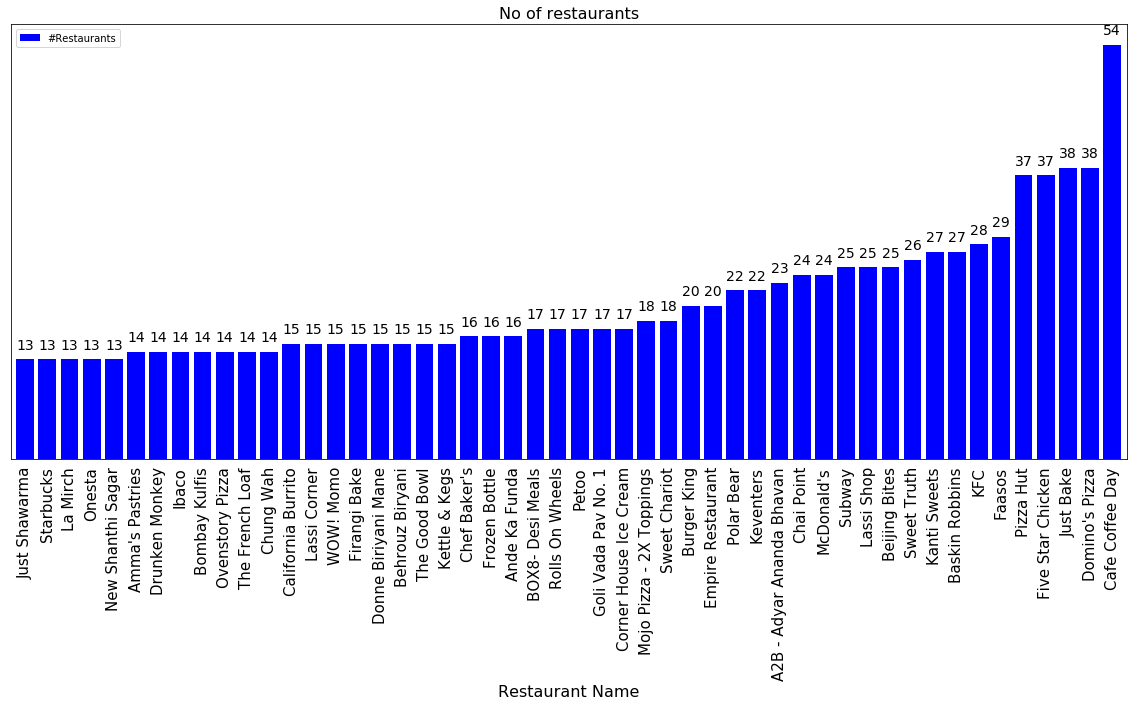

In [31]:
ax = histo.plot(kind='bar', figsize=(20, 8), rot=90, width = 0.8, color=[ 'blue'])
rects = ax.patches
labels = list(histo)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 1, label,
            ha='center', va='bottom', fontsize=14)
ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on') # remove borders
ax.xaxis.set_tick_params(labelsize=15) # set xticks as 14
ax.legend(fontsize=14) # set legend sie as 14
ax.set_title('No of restaurants', fontsize=16) # set title and add font size as 16
ax.set_xlabel('Restaurant Name', fontsize=16)
#ax.grid(False)  # remove grid
ax.set_facecolor("white") # set bg color white
ax.legend(['#Restaurants'])

In [ ]:
from subprocess import check_output
from wordcloud import WordCloud
wordcloud = (WordCloud(width=1440, height=1080, relative_scaling=0.5).generate_from_frequencies(rest_df['name'].value_counts()))


fig = plt.figure(1,figsize=(15, 15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<img src="https://i.ibb.co/sw1PSWv/wordcloud.png" alt="wordcloud" height="1500" width="1500">

Clearly CCD(Cafe) has the most number of restaurants in Bengaluru, followed by Domino's Pizza

### Delivery Restaurant and Table Book

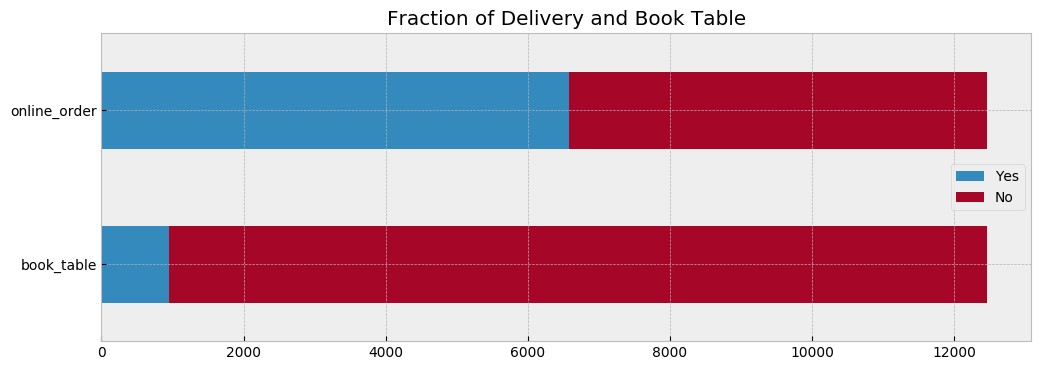

In [121]:
with plt.style.context('bmh', after_reset = True):
    plt.figure(figsize = (12,4))
    ax = plt.subplot(1,1,1)
    tmp = {}
    for col in ['online_order', 'book_table']: 
        tmp[col] = rest_df[col].value_counts()
    tmp = pd.DataFrame.from_dict(tmp, orient = 'index')
    tmp.plot.barh(stacked = True, ax = ax)
    ax.set_title('Fraction of Delivery and Book Table')
    plt.show()


#### Lets take the rating of restaurant and find the average rating for each of the neighborhood

In [151]:
rest_df['rate'] = rest_df['rate'].str.split('/').str[0]

Lets set the rating of new restaurants as NULL

In [154]:
rest_df.loc[rest_df['rate']=="NEW", 'rate'] = np.nan
rest_df.loc[rest_df['rate']=="-", 'rate'] = np.nan

In [155]:
rest_df['rate'] = rest_df['rate'].astype('float')

In [75]:
rest_df.groupby(['location'])['rate'].mean().sort_values()[-50:][:-1]

location
Whitefield               3.548363
HBR Layout               3.553333
Basaveshwara Nagar       3.554167
Rajajinagar              3.562500
Old Airport Road         3.566116
Mysore Road              3.566667
Koramangala 1st Block    3.569600
Banashankari             3.570683
JP Nagar                 3.577262
Koramangala 2nd Block    3.577778
HSR                      3.585231
Vijay Nagar              3.588462
Kammanahalli             3.597080
Yelahanka                3.600000
Frazer Town              3.614189
New BEL Road             3.614348
Basavanagudi             3.622396
Sahakara Nagar           3.629268
Koramangala 8th Block    3.643750
Brigade Road             3.646018
Ulsoor                   3.647917
Langford Town            3.650000
Kalyan Nagar             3.676098
Koramangala 6th Block    3.686525
Malleshwaram             3.692925
Vasanth Nagar            3.697778
Kengeri                  3.700000
Central Bangalore        3.700000
Koramangala              3.716667
Jayan

Clearly Lavelle Road restaurants are rated higher

### Number of restaurants in each Neighborhood

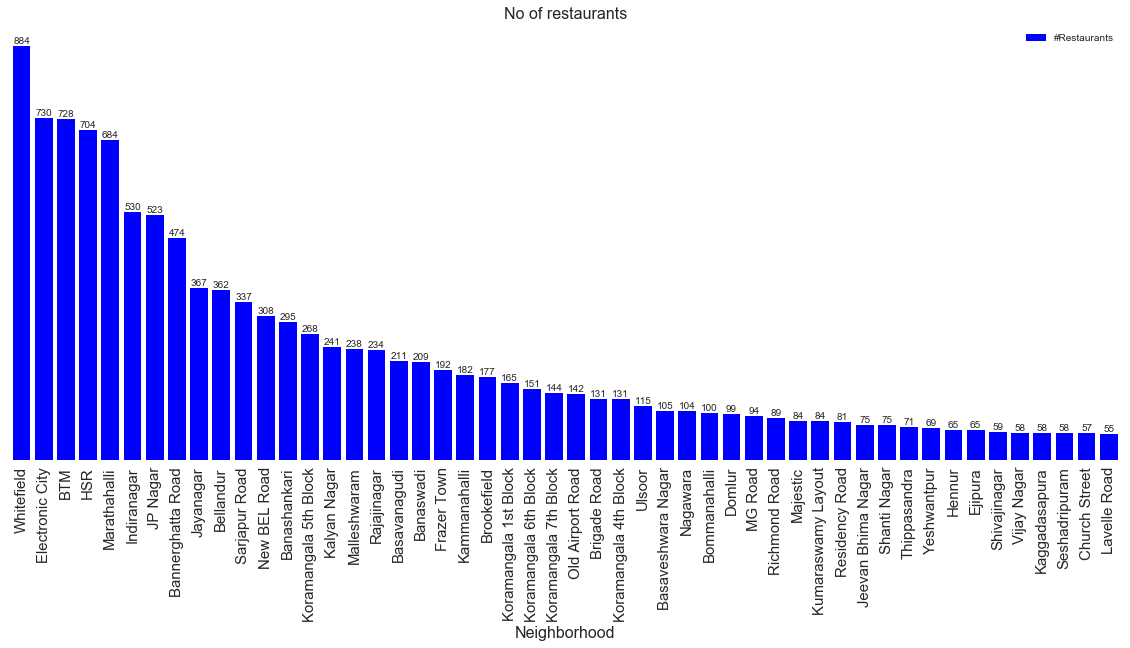

In [363]:
histo = rest_df.groupby('location')['url'].count().sort_values(ascending=False)[:50]
ax = histo.plot(kind='bar', figsize=(20, 8), rot=90, width = 0.8, color=[ 'blue'])
rects = ax.patches
labels = list(histo)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + .05, label,
            ha='center', va='bottom', fontsize=10)
ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on') # remove borders
ax.xaxis.set_tick_params(labelsize=15) # set xticks as 14
ax.legend(fontsize=14) # set legend sie as 14
ax.set_title('No of restaurants', fontsize=16) # set title and add font size as 16
ax.set_xlabel('Neighborhood', fontsize=16)
#ax.grid(False)  # remove grid
ax.set_facecolor("white") # set bg color white
ax.legend(['#Restaurants'])

Whitefield has the highest number of restaurants followed by EC

### Zomato's Presence across Bangalore

In [216]:
labels = list(rest_df.location.value_counts().index)
values = list(rest_df.location.value_counts().values)

fig = {
    "data":[
        {
            "labels" : labels,
            "values" : values,
            "hoverinfo" : 'label+percent',
            "domain": {"x": [0, .9]},
            "hole" : 0.6,
            "type" : "pie",
            "rotation":120,
        },
    ],
    "layout": {
        "title" : "Zomato's Presence in Bangalore",
        "annotations": [
            {
                "font": {"size":20},
                "showarrow": True,
                "text": "Neighborhood",
                "x":0.2,
                "y":0.9,
            },
        ]
    }
}

iplot(fig)

### Lets get the coordinates for each of the neighborhood

In [31]:
location = [x for x in rest_df['location'].unique().tolist() if type(x) == str]
latitude = []
longitude =  []
for i in range(0, len(location)):
    if(type(location[i]) == str):
        ctr=0
        while True:
            try:
                address = location[i] + ', Bengaluru, India'
                geolocator = Nominatim(user_agent="ny_explorer")
                loc = geolocator.geocode(address)
                latitude.append(loc.latitude)
                longitude.append(loc.longitude)
                print('The geograpical coordinate of location are {}, {}.'.format(loc.latitude, loc.longitude))
            except:
                ctr+=1
                if(ctr==7):
                    print(i)
                    latitude.append(address)
                    longitude.append(address)
                    break
                continue
            break

The geograpical coordinate of location are 12.91538175, 77.5736376995009.
The geograpical coordinate of location are 12.9417261, 77.5755021.
The geograpical coordinate of location are 12.9597523, 77.5561291.
The geograpical coordinate of location are 12.9292731, 77.5824229.
The geograpical coordinate of location are 12.9068169, 77.5635247362134.
The geograpical coordinate of location are 12.9274278, 77.5153722.
The geograpical coordinate of location are 12.96627425, 77.6127051647936.
The geograpical coordinate of location are 12.9055682, 77.5455438.
The geograpical coordinate of location are 12.9072515, 77.5782713.
The geograpical coordinate of location are 12.9791198, 77.5912997.
The geograpical coordinate of location are 12.965718, 77.5762705372058.
The geograpical coordinate of location are 12.9651008, 77.5078635.
The geograpical coordinate of location are 12.9205791, 77.6001168.
The geograpical coordinate of location are 12.91127585, 77.6045654343118.
The geograpical coordinate of 

In [92]:
rest_df['location_latitude'] = rest_df['location'].map(dict(zip(location, latitude)))
rest_df['location_longitude'] = rest_df['location'].map(dict(zip(location, longitude)))

In [217]:
dataframe_filtered = rest_df.groupby(['location'])['location_latitude', 'location_longitude'].first()
dataframe_filtered['no_restaurant'] = rest_df.groupby(['location'])['url'].count()
venues_map = folium.Map(location=[12.934533, 77.626579], zoom_start=11) # generate map centred around Bengaluru

states = folium.map.FeatureGroup()
i=0
for lat, lng, in zip(dataframe_filtered.location_latitude, dataframe_filtered.location_longitude):
    states.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
        )
    )
    i+=1
i=0
for lat, lng, in zip(dataframe_filtered.location_latitude, dataframe_filtered.location_longitude):
    states.add_child(
        folium.features.Marker(
            [lat, lng],
            popup= dataframe_filtered.index[i],
        )
    )
    i+=1
# add incidents to map
venues_map.add_child(states)
venues_map

### Plot map by density of restaurants in each neighborhood

In [219]:
bins = pd.IntervalIndex.from_tuples([(0, 100), (101, 200), (201, 300), (301, 400), (401, 500), (501, 600), (601, 700), (701, 800), (801, 900)])
dataframe_filtered['category'] = pd.cut(dataframe_filtered['no_restaurant'], bins)

In [220]:
x = dataframe_filtered.groupby('category').groups.keys()

In [221]:
venues_map = folium.Map(location=[12.934533, 77.626579], zoom_start=11) # generate map centred around Bengaluru

states = folium.map.FeatureGroup()
i=0
for lat, lng, in zip(dataframe_filtered.location_latitude, dataframe_filtered.location_longitude):
    states.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
        )
    )
    i+=1
colors = ['red', 'blue', 'green', 'purple', 'orange', 'white', 'pink', 'gray', 'black']
j=0
for i in range(0,len(list(x))):
    group = dataframe_filtered.groupby('category').get_group(list(x)[i])
    i=0
    for lat, lng, in zip(group.location_latitude, group.location_longitude):
        states.add_child(
            folium.features.Marker(
                [lat, lng],
                popup= group.index[i],
                icon=folium.Icon(color=colors[j], icon='cloud')
            )
        )
        i+=1
    j+=1
# add incidents to map
venues_map.add_child(states)

# url = ('https://raw.githubusercontent.com/SECOORA/static_assets/'
#        'master/maps/img/rose.png')
# FloatImage(image_file, bottom=40, left=65).add_to(venues_map)
from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Number of restaurants</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:red;opacity:0.7;'></span>0-100</li>
    <li><span style='background:blue;opacity:0.7;'></span>101-200</li>
    <li><span style='background:green;opacity:0.7;'></span>201-300</li>
    <li><span style='background:purple;opacity:0.7;'></span>301-400</li>
    <li><span style='background:orange;opacity:0.7;'></span>401-500</li>
    <li><span style='background:white;opacity:0.7;'></span>501-600</li>
    <li><span style='background:pink;opacity:0.7;'></span>601-700</li>
    <li><span style='background:gray;opacity:0.7;'></span>701-800</li>
    <li><span style='background:black;opacity:0.7;'></span>801-900</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

venues_map.get_root().add_child(macro)

venues_map


It can be seen clearly that outer cities of Bengaluru has most number of restaurants. But wait is that true ?<br>
Analysing the data we found that central bengaluru is densely populated while there aren't much markers at the outer part of the city.

### Neighborhood by rating

In [222]:
nb_rate_df = rest_df.groupby(['location'])['location_latitude', 'location_longitude'].first()
nb_rate_df['rate'] = rest_df.groupby(['location'])['rate'].mean()
nb_rate_df

location_latitude  location_longitude      rate
location                                                                      
BTM                                    12.911276           77.604565  3.556950
Banashankari                           12.915382           77.573638  3.625991
Banaswadi                              13.014162           77.651854  3.477397
Bannerghatta Road                      12.920579           77.600117  3.476000
Basavanagudi                           12.941726           77.575502  3.675141
Basaveshwara Nagar                     12.993224           77.539158  3.595522
Bellandur                              12.979120           77.591300  3.493436
Bommanahalli                           12.908945           77.623904  3.218519
Brigade Road                           12.973613           77.607472  3.675926
Brookefield                            12.961570           77.709180  3.570000
CV Raman Nagar                         12.980300           77.651990  3.500000
Central Bangalore                      12.979120           77.591300  3.700000
Church Street                          12.975200           77.604141  3.898148
City Market                            12.965718           77.576271  3.552381
Commercial Street                      12.982193           77.608313  3.564706
Cunningham Road                        12.986891           77.595030  3.736170
Domlur                                 12.962467           77.638196  3.517568
East Bangalore                         12.979120           77.591300  3.464286
Ejipura                                12.945245           77.626914  3.473529
Electronic City                        12.836290           77.657580  3.472271
Frazer Town                            12.996845           77.613017  3.631250
HBR Layout                             13.035870           77.632360  3.664000
HSR                                    12.914453           77.642694  3.637403
Hebbal                                 13.038218           77.591900  3.600000
Hennur                                 13.025809           77.630507  3.457447
Hosur Road                             12.929565           77.615163  3.810000
ITPL Main Road, Whitefield             12.967576           77.715088  3.579412
Indiranagar                            12.973291           77.640467  3.783141
Infantry Road                          12.983177           77.595831  3.753846
JP Nagar                               12.907251           77.578271  3.634677
...                                          ...                 ...       ...
Old Madras Road                        13.007609           77.690023  3.355556
Peenya                                 13.032942           77.527325  3.200000
RT Nagar                               13.022720           77.595715  3.475000
Race Course Road                       12.980696           77.577429  3.862069
Rajajinagar                            12.988234           77.554883  3.594828
Rajarajeshwari Nagar                   12.927428           77.515372  3.850000
Rammurthy Nagar                        13.031010           77.675110  3.353333
Residency Road                         13.053000           77.620483  3.835211
Richmond Road                          12.966260           77.606716  3.840323
Sadashiv Nagar                         13.007050           77.578840  3.789286
Sahakara Nagar                         13.062147           77.580061  3.645000
Sanjay Nagar                           12.957866           77.695875  3.562069
Sankey Road                            12.989950           77.585838  4.041667
Sarjapur Road                          12.924484           77.650272  3.604400
Seshadripuram                          12.993188           77.575342  3.723913
Shanti Nagar                           12.957555           77.597910  3.502083
Shivajinagar                           12.986391           77.607542  3.474194
South Bangalore                        12.979120           77.591300  3.450000
St

In [223]:
bins = pd.IntervalIndex.from_tuples([(3.2, 3.3), (3.31, 3.4), (3.41, 3.5), (3.51, 3.6), (3.61, 3.7), (3.71, 3.8), (3.81, 3.9), (3.91, 4.0), (4.0, 4.1)])
nb_rate_df['category'] = pd.cut(nb_rate_df['rate'], bins)

In [224]:
x = nb_rate_df.groupby('category').groups.keys()

In [225]:
venues_map = folium.Map(location=[12.934533, 77.626579], zoom_start=11) # generate map centred around Bengaluru

states = folium.map.FeatureGroup()
i=0
for lat, lng, in zip(nb_rate_df.location_latitude, nb_rate_df.location_longitude):
    states.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
        )
    )
    i+=1
colors = ['red', 'blue', 'green', 'purple', 'orange', 'white', 'pink', 'gray', 'black']
j=0
for i in range(0,len(list(x))):
    group = nb_rate_df.groupby('category').get_group(list(x)[i])
    i=0
    for lat, lng, in zip(group.location_latitude, group.location_longitude):
        states.add_child(
            folium.features.Marker(
                [lat, lng],
                popup= group.index[i],
                icon=folium.Icon(color=colors[j], icon='cloud')
            )
        )
        i+=1
    j+=1
# add incidents to map
venues_map.add_child(states)

# url = ('https://raw.githubusercontent.com/SECOORA/static_assets/'
#        'master/maps/img/rose.png')
# FloatImage(image_file, bottom=40, left=65).add_to(venues_map)
from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Number of restaurants</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:red;opacity:0.7;'></span>3.2-3.3</li>
    <li><span style='background:blue;opacity:0.7;'></span>3.31-3.4</li>
    <li><span style='background:green;opacity:0.7;'></span>3.41-3.5</li>
    <li><span style='background:purple;opacity:0.7;'></span>3.51-3.6</li>
    <li><span style='background:orange;opacity:0.7;'></span>3.61-3.7</li>
    <li><span style='background:white;opacity:0.7;'></span>3.71-3.8</li>
    <li><span style='background:pink;opacity:0.7;'></span>3.81-3.9</li>
    <li><span style='background:gray;opacity:0.7;'></span>3.91-4.0</li>
    <li><span style='background:black;opacity:0.7;'></span>4.04.1</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

venues_map.get_root().add_child(macro)

venues_map


Most of the top rated restaurants are clustered around Central Bengaluru

### Neighborhood by cost of food

#### Lets see the cost of food in each neighborhood of Bengaluru

In [ ]:
rest_df['approx_cost(for two people)'] = rest_df['approx_cost(for two people)'].str.replace(",","").astype(float)

But before that lets remove all those places that has less than 50 restaurants

In [228]:
above_50 = rest_df.groupby('location')['url'].count()[rest_df.groupby('location')['url'].count() >= 50].index

##### Does this mean higher the cost of food means posche area

In [229]:
rest_df[rest_df['location'].isin(above_50)].groupby('location')['approx_cost(for two people)'].mean().sort_values(ascending= False)

location
Lavelle Road             1292.727273
MG Road                  1052.127660
Residency Road            949.382716
Church Street             762.280702
Richmond Road             736.516854
Seshadripuram             733.620690
Vasanth Nagar             719.444444
Ulsoor                    687.280702
Old Airport Road          637.304965
Indiranagar               601.064639
Koramangala 4th Block     595.038168
Brigade Road              594.122137
Koramangala 5th Block     578.113208
Whitefield                558.293515
Domlur                    553.020833
Koramangala 6th Block     548.666667
Koramangala 7th Block     525.524476
Kalyan Nagar              523.941909
Sarjapur Road             489.071856
Marathahalli              485.315712
Malleshwaram              484.117647
Bellandur                 481.712707
Electronic City           461.714678
JP Nagar                  457.777778
Jayanagar                 444.277929
HSR                       440.285307
New BEL Road              435

Cost of living in Lavelle Road is also quite high, even I can't afford the restaurants in lavelle road

<font size=2px><b> Lets see it on the map</b></font>

In [230]:
nb_cost_df = rest_df.groupby(['location'])['location_latitude', 'location_longitude'].first()
nb_cost_df['cost'] = rest_df.groupby(['location'])['approx_cost(for two people)'].mean()
nb_cost_df

location_latitude  location_longitude  \
location                                                               
BTM                                    12.911276           77.604565   
Banashankari                           12.915382           77.573638   
Banaswadi                              13.014162           77.651854   
Bannerghatta Road                      12.920579           77.600117   
Basavanagudi                           12.941726           77.575502   
Basaveshwara Nagar                     12.993224           77.539158   
Bellandur                              12.979120           77.591300   
Bommanahalli                           12.908945           77.623904   
Brigade Road                           12.973613           77.607472   
Brookefield                            12.961570           77.709180   
CV Raman Nagar                         12.980300           77.651990   
Central Bangalore                      12.979120           77.591300   
Church Street                          12.975200           77.604141   
City Market                            12.965718           77.576271   
Commercial Street                      12.982193           77.608313   
Cunningham Road                        12.986891           77.595030   
Domlur                                 12.962467           77.638196   
East Bangalore                         12.979120           77.591300   
Ejipura                                12.945245           77.626914   
Electronic City                        12.836290           77.657580   
Frazer Town                            12.996845           77.613017   
HBR Layout                             13.035870           77.632360   
HSR                                    12.914453           77.642694   
Hebbal                                 13.038218           77.591900   
Hennur                                 13.025809           77.630507   
Hosur Road                             12.929565           77.615163   
ITPL Main Road, Whitefield             12.967576           77.715088   
Indiranagar                            12.973291           77.640467   
Infantry Road                          12.983177           77.595831   
JP Nagar                               12.907251           77.578271   
...                                          ...                 ...   
Old Madras Road                        13.007609           77.690023   
Peenya                                 13.032942           77.527325   
RT Nagar                               13.022720           77.595715   
Race Course Road                       12.980696           77.577429   
Rajajinagar                            12.988234           77.554883   
Rajarajeshwari Nagar                   12.927428           77.515372   
Rammurthy Nagar                        13.031010           77.675110   
Residency Road                         13.053000           77.620483   
Richmond Road                          12.966260           77.606716   
Sadashiv Nagar                         13.007050           77.578840   
Sahakara Nagar                         13.062147           77.580061   
Sanjay Nagar                           12.957866           77.695875   
Sankey Road                            12.989950           77.585838   
Sarjapur Road                          12.924484           77.650272   
Seshadripuram                          12.993188           77.575342   
Shanti Nagar                           12.957555           77.597910   
Shivajinagar                           12.986391           77.607542   
South Bangalore                        12.979120           77.591300   
St. Marks Road                         12.977906           77.602201   
Thippasandra                           12.973936           77.650998   
Ulsoor                                 12.977879           77.624670   
Uttarahalli                            12.905568           77.545544   
Varthur Main Road, Whitefield          12.941466           77.747094   

In [231]:
bins = pd.IntervalIndex.from_tuples([(200, 600), (601, 1000), (1001, 1400), (2201, 2600)])
nb_cost_df['category'] = pd.cut(nb_cost_df['cost'], bins)

In [232]:
x = nb_cost_df.groupby('category').groups.keys()
venues_map = folium.Map(location=[12.934533, 77.626579], zoom_start=11) # generate map centred around Bengaluru

states = folium.map.FeatureGroup()
i=0
for lat, lng, in zip(nb_cost_df.location_latitude, nb_cost_df.location_longitude):
    states.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
        )
    )
    i+=1
colors = ['red', 'blue', 'green', 'purple', 'orange', 'black']
j=0
for i in range(0,len(list(x))):
    group = nb_cost_df.groupby('category').get_group(list(x)[i])
    i=0
    for lat, lng, in zip(group.location_latitude, group.location_longitude):
        states.add_child(
            folium.features.Marker(
                [lat, lng],
                popup= group.index[i],
                icon=folium.Icon(color=colors[j], icon='cloud')
            )
        )
        i+=1
    j+=1
# add incidents to map
venues_map.add_child(states)

# url = ('https://raw.githubusercontent.com/SECOORA/static_assets/'
#        'master/maps/img/rose.png')
# FloatImage(image_file, bottom=40, left=65).add_to(venues_map)
from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Cost</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:red;opacity:0.7;'></span>200-600</li>
    <li><span style='background:blue;opacity:0.7;'></span>601-1000</li>
    <li><span style='background:green;opacity:0.7;'></span>1001-1400</li>
    <li><span style='background:purple;opacity:0.7;'></span>2201-2600</li>
  </ul>
</div>
</div>
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

venues_map.get_root().add_child(macro)

venues_map


It can be seen that all the costly restaurants are located in Central Bangalore, Lavelle Road, MG Road, Race Course Road.

Yes it can therefore be said from higher cost of food means posche area comparing it to the ground truth of Bangalore

### Grouping the neighborhood by the type of restaurant 

In [300]:
types = set()
def func(x):
    if(type(x) == list):
        print(x)
        for y in x:
            types.add(y.strip())
_ = rest_df['rest_type'].str.split(',').apply(func)

In [284]:
column_names = list(types)
# instantiate the dataframe
neighborhood = pd.DataFrame(columns=column_names)
neighborhood

Empty DataFrame
Columns: [Pop Up, Bhojanalya, Pub, Lounge, Microbrewery, Bar, Quick Bites, Takeaway, Fine Dining, Delivery, Beverage Shop, Dhaba, Sweet Shop, Irani Cafee, Food Court, Meat Shop, Cafe, Food Truck, Casual Dining, Kiosk, Confectionery, Club, Bakery, Mess, Dessert Parlor]
Index: []

[0 rows x 25 columns]

In [285]:
neighborhood['neighborhood'] = rest_df.groupby('location').groups.keys()
neighborhood = neighborhood.set_index('neighborhood').fillna(0)
neighborhood

Pop Up  Bhojanalya  Pub  Lounge  Microbrewery  \
neighborhood                                                                   
BTM                                 0           0    0       0             0   
Banashankari                        0           0    0       0             0   
Banaswadi                           0           0    0       0             0   
Bannerghatta Road                   0           0    0       0             0   
Basavanagudi                        0           0    0       0             0   
Basaveshwara Nagar                  0           0    0       0             0   
Bellandur                           0           0    0       0             0   
Bommanahalli                        0           0    0       0             0   
Brigade Road                        0           0    0       0             0   
Brookefield                         0           0    0       0             0   
CV Raman Nagar                      0           0    0       0             0   
Central Bangalore                   0           0    0       0             0   
Church Street                       0           0    0       0             0   
City Market                         0           0    0       0             0   
Commercial Street                   0           0    0       0             0   
Cunningham Road                     0           0    0       0             0   
Domlur                              0           0    0       0             0   
East Bangalore                      0           0    0       0             0   
Ejipura                             0           0    0       0             0   
Electronic City                     0           0    0       0             0   
Frazer Town                         0           0    0       0             0   
HBR Layout                          0           0    0       0             0   
HSR                                 0           0    0       0             0   
Hebbal                              0           0    0       0             0   
Hennur                              0           0    0       0             0   
Hosur Road                          0           0    0       0             0   
ITPL Main Road, Whitefield          0           0    0       0             0   
Indiranagar                         0           0    0       0             0   
Infantry Road                       0           0    0       0             0   
JP Nagar                            0           0    0       0             0   
...                               ...         ...  ...     ...           ...   
Old Madras Road                     0           0    0       0             0   
Peenya                              0           0    0       0             0   
RT Nagar                            0           0    0       0             0   
Race Course Road                    0           0    0       0             0   
Rajajinagar                         0           0    0       0             0   
Rajarajeshwari Nagar                0           0    0       0             0   
Rammurthy Nagar                     0           0    0       0             0   
Residency Road                      0           0    0       0             0   
Richmond Road                       0           0    0       0             0   
Sadashiv Nagar                      0           0    0       0             0   
Sahakara Nagar                      0           0    0       0             0   
Sanjay Nagar                        0           0    0       0             0   
Sankey Road                         0           0    0       0             0   
Sarjapur Road                       0           0    0       0             0   
Seshadripuram                       0           0    0       0             0   
Shanti Nagar                        0           0    0       0             0   
Shivajinagar                        0           0    0       0             0   
South Bangalore                

In [286]:
i=0
for i in range(0,len(rest_df)):
    for x in types:
        if type(rest_df.loc[i, 'rest_type']) == str and x in rest_df.loc[i, 'rest_type']:
            neighborhood.loc[rest_df.loc[i, 'location'], x] = neighborhood.loc[rest_df.loc[i, 'location'], x]+1

In [289]:
# Koramangala is divided into different block, lets combine them all
koramangala = ['Koramangala', 'Koramangala 1st Block', 'Koramangala 2nd Block', 'Koramangala 3rd Block', 'Koramangala 4th Block', 
'Koramangala 5th Block', 'Koramangala 6th Block', 'Koramangala 7th Block', 'Koramangala 8th Block']
koramangala_dict = dict(neighborhood.loc[koramangala].sum())
neighborhood = neighborhood.drop(koramangala)
neighborhood.loc['Koramangala'] = koramangala_dict

In [290]:
neighborhood

Pop Up  Bhojanalya  Pub  Lounge  Microbrewery  \
neighborhood                                                                   
BTM                                 0           0    1       0             1   
Banashankari                        0           0    1       1             0   
Banaswadi                           0           0    1       0             0   
Bannerghatta Road                   0           0    1       2             1   
Basavanagudi                        0           0    1       0             0   
Basaveshwara Nagar                  0           0    1       0             0   
Bellandur                           0           0    2       2             0   
Bommanahalli                        0           0    0       0             0   
Brigade Road                        0           0    5       1             2   
Brookefield                         0           0    2       0             0   
CV Raman Nagar                      0           0    0       0             0   
Central Bangalore                   0           0    0       0             0   
Church Street                       0           0    2       2             0   
City Market                         0           0    0       0             0   
Commercial Street                   0           0    0       0             0   
Cunningham Road                     0           0    1       1             0   
Domlur                              0           0    1       1             1   
East Bangalore                      0           0    0       0             0   
Ejipura                             0           0    0       0             0   
Electronic City                     0           0    4       5             1   
Frazer Town                         0           0    2       1             0   
HBR Layout                          0           0    1       0             0   
HSR                                 0           0    2       4             0   
Hebbal                              0           0    0       0             0   
Hennur                              0           0    0       0             0   
Hosur Road                          0           0    0       0             0   
ITPL Main Road, Whitefield          0           1    0       0             0   
Indiranagar                         0           0   11       8             3   
Infantry Road                       0           0    0       0             0   
JP Nagar                            0           0    5       2             4   
...                               ...         ...  ...     ...           ...   
Peenya                              0           0    0       0             0   
RT Nagar                            0           0    0       0             0   
Race Course Road                    0           0    0       1             0   
Rajajinagar                         0           0    0       1             0   
Rajarajeshwari Nagar                0           0    0       0             0   
Rammurthy Nagar                     0           0    0       0             0   
Residency Road                      0           0    2       4             3   
Richmond Road                       0           0    0       0             0   
Sadashiv Nagar                      0           0    0       0             0   
Sahakara Nagar                      0           0    0       0             1   
Sanjay Nagar                        0           0    0       0             0   
Sankey Road                         0           0    0       1             0   
Sarjapur Road                       0           0    5       1             5   
Seshadripuram                       0           0    1       3             0   
Shanti Nagar                        0           0    1       0             0   
Shivajinagar                        0           0    0       0             0   
South Bangalore                     0           0    0       0             0   
St. Marks Road                 

#### Swarm plot

In [291]:
dfs = neighborhood.reset_index().melt('neighborhood', var_name='cols',  value_name='vals')

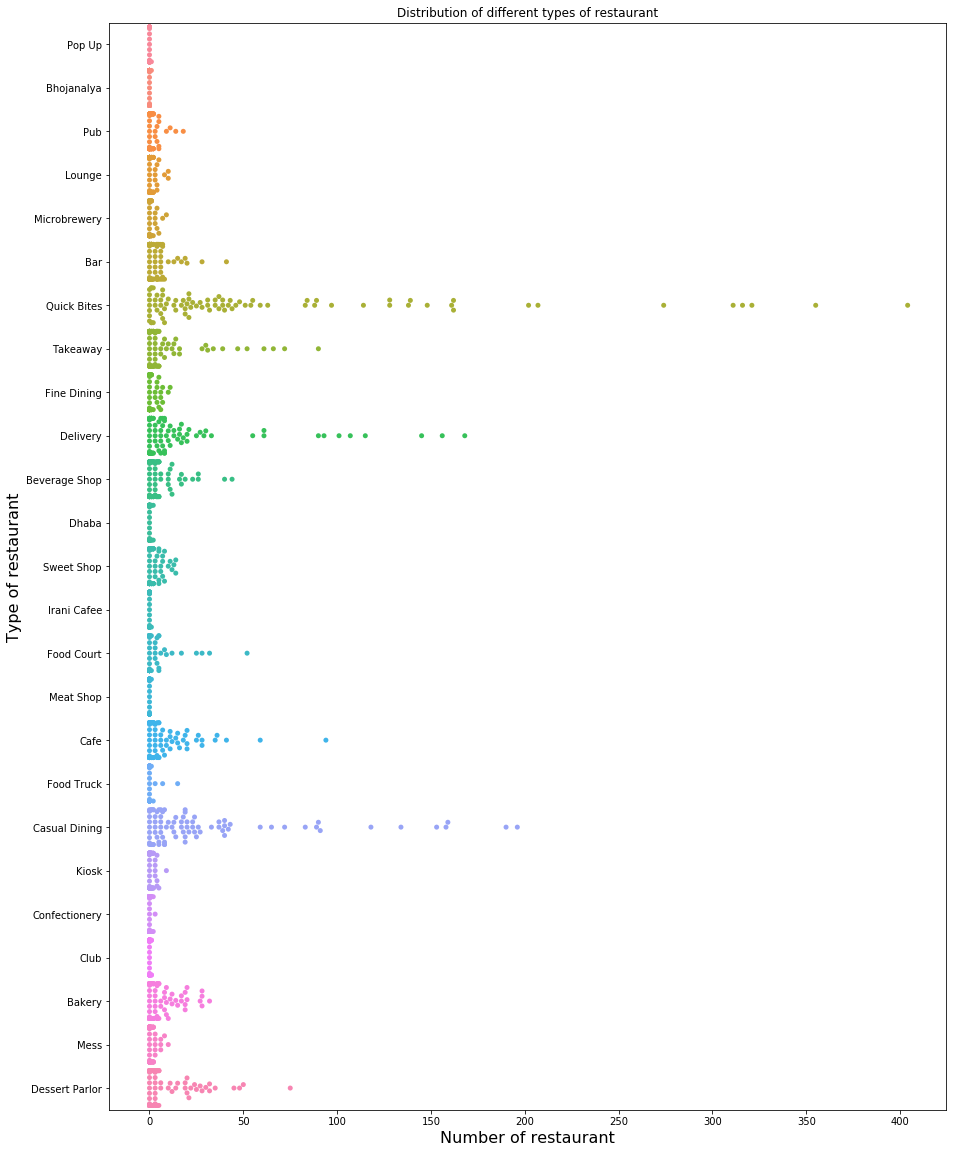

In [292]:
plt.figure(figsize=(15,20))
ax = sns.swarmplot(x="vals", y="cols", data=dfs)
ax.set_xlabel('Number of restaurant', fontsize=16)
ax.set_ylabel('Type of restaurant', fontsize=16)
ax.set_title('Distribution of different types of restaurant')
plt.savefig("swarm.png")

It can be seen that there are more number of Quick Bites restaurants followed by Delivery restaurant which was Quite obvious to us.

### Grouping the neighborhood by the cuisines
Is there any neighborhood that is more famous for its cuisines

In [325]:
types = set()
def func(x):
    if(type(x) == list):
        for y in x:
            types.add(y.strip())
_ = rest_df['cuisines'].str.split(',').apply(func)

In [326]:
column_names = list(types)
# instantiate the dataframe
neighborhood_cns = pd.DataFrame(columns=column_names)
neighborhood_cns

Empty DataFrame
Columns: [Goan, Seafood, Korean, North Indian, African, Bakery, Chinese, Continental, Australian, Thai, Sushi, South Indian, South American, Sindhi, Ice Cream, Portuguese, Naga, Jewish, Turkish, Bubble Tea, Rajasthani, BBQ, Sandwich, Fast Food, Hyderabadi, Wraps, Greek, Biryani, Awadhi, Momos, Andhra, Spanish, Gujarati, Steak, Tex-Mex, Russian, Lebanese, Arabian, Rolls, Healthy Food, Malwani, Lucknowi, Singaporean, Desserts, Finger Food, Chettinad, Pizza, Vietnamese, Modern Indian, Hot dogs, Italian, Maharashtrian, Konkan, Tea, Mediterranean, Afghan, Pan Asian, Sri Lankan, Cantonese, British, Kebab, Bohri, Parsi, Paan, American, Japanese, Mexican, Indonesian, Oriya, Burmese, Bengali, Mangalorean, Coffee, Salad, European, French, Malaysian, North Eastern, Vegan, Bihari, Charcoal Chicken, Belgian, Beverages, Mongolian, Afghani, Street Food, Kerala, Bar Food, Asian, Raw Meats, Mithai, German, Juices, Grill, Drinks Only, Cafe, Mughlai, Burger, Tamil, Tibetan, ...]
Index: []

[0 rows x 107 columns]

In [327]:
neighborhood_cns['neighborhood'] = rest_df.groupby('location').groups.keys()
neighborhood_cns = neighborhood_cns.set_index('neighborhood').fillna(0)
neighborhood_cns

Goan  Seafood  Korean  North Indian  African  \
neighborhood                                                                  
BTM                               0        0       0             0        0   
Banashankari                      0        0       0             0        0   
Banaswadi                         0        0       0             0        0   
Bannerghatta Road                 0        0       0             0        0   
Basavanagudi                      0        0       0             0        0   
Basaveshwara Nagar                0        0       0             0        0   
Bellandur                         0        0       0             0        0   
Bommanahalli                      0        0       0             0        0   
Brigade Road                      0        0       0             0        0   
Brookefield                       0        0       0             0        0   
CV Raman Nagar                    0        0       0             0        0   
Central Bangalore                 0        0       0             0        0   
Church Street                     0        0       0             0        0   
City Market                       0        0       0             0        0   
Commercial Street                 0        0       0             0        0   
Cunningham Road                   0        0       0             0        0   
Domlur                            0        0       0             0        0   
East Bangalore                    0        0       0             0        0   
Ejipura                           0        0       0             0        0   
Electronic City                   0        0       0             0        0   
Frazer Town                       0        0       0             0        0   
HBR Layout                        0        0       0             0        0   
HSR                               0        0       0             0        0   
Hebbal                            0        0       0             0        0   
Hennur                            0        0       0             0        0   
Hosur Road                        0        0       0             0        0   
ITPL Main Road, Whitefield        0        0       0             0        0   
Indiranagar                       0        0       0             0        0   
Infantry Road                     0        0       0             0        0   
JP Nagar                          0        0       0             0        0   
Jakkur                            0        0       0             0        0   
Jalahalli                         0        0       0             0        0   
Jayanagar                         0        0       0             0        0   
Jeevan Bhima Nagar                0        0       0             0        0   
KR Puram                          0        0       0             0        0   
Kaggadasapura                     0        0       0             0        0   
Kalyan Nagar                      0        0       0             0        0   
...                             ...      ...     ...           ...      ...   
Marathahalli                      0        0       0             0        0   
Mysore Road                       0        0       0             0        0   
Nagarbhavi                        0        0       0             0        0   
Nagawara                          0        0       0             0        0   
New BEL Road                      0        0       0             0        0   
North Bangalore                   0        0       0             0        0   
Old Airport Road                  0        0       0             0        0   
Old Madras Road                   0        0       0             0        0   
Peenya                            0        0       0             0        0   
RT Nagar                          0        0       0             0        0   
Race Course Road                  0        0       0             0        0   
Ra

In [328]:
i=0
for i in range(0,len(rest_df)):
    for x in types:
        if type(rest_df.loc[i, 'cuisines']) == str and x in rest_df.loc[i, 'cuisines']:
            neighborhood_cns.loc[rest_df.loc[i, 'location'], x] = neighborhood_cns.loc[rest_df.loc[i, 'location'], x]+1

In [329]:
neighborhood_cns

Goan  Seafood  Korean  North Indian  African  \
neighborhood                                                                  
BTM                               0       16       0           335        0   
Banashankari                      0        6       1            93        0   
Banaswadi                         0        4       0            74        0   
Bannerghatta Road                 0       18       0           200        1   
Basavanagudi                      0        3       0            50        0   
Basaveshwara Nagar                0        3       0            32        0   
Bellandur                         0        4       0           172        0   
Bommanahalli                      0        1       0            50        0   
Brigade Road                      0        6       1            32        0   
Brookefield                       0        5       0            74        0   
CV Raman Nagar                    0        1       0            16        0   
Central Bangalore                 0        0       0             0        0   
Church Street                     0        3       0            20        0   
City Market                       0        1       0            21        0   
Commercial Street                 0        0       0             9        0   
Cunningham Road                   0        3       0            18        0   
Domlur                            1        6       0            41        0   
East Bangalore                    1        0       0             7        0   
Ejipura                           0        1       0            27        0   
Electronic City                   0       25       0           375        0   
Frazer Town                       0        4       0            50        0   
HBR Layout                        0        1       0            14        0   
HSR                               0       20       1           292        0   
Hebbal                            0        0       0             2        0   
Hennur                            0        2       0            25        0   
Hosur Road                        0        1       0             9        0   
ITPL Main Road, Whitefield        0        0       0            21        0   
Indiranagar                       0       21       4           166        1   
Infantry Road                     0        1       1             7        0   
JP Nagar                          0       19       0           211        0   
Jakkur                            0        0       0             1        0   
Jalahalli                         0        2       0             9        0   
Jayanagar                         0       14       0           116        0   
Jeevan Bhima Nagar                0        5       0            30        0   
KR Puram                          0        0       0             8        0   
Kaggadasapura                     0        2       0            27        0   
Kalyan Nagar                      1        7       2            73        0   
...                             ...      ...     ...           ...      ...   
Marathahalli                      0       15       1           366        0   
Mysore Road                       0        0       0             7        0   
Nagarbhavi                        0        0       0             2        0   
Nagawara                          0        3       0            48        0   
New BEL Road                      0        5       0           129        0   
North Bangalore                   0        0       0             4        0   
Old Airport Road                  0        1       0            61        0   
Old Madras Road                   0        0       0             4        0   
Peenya                            0        0       0             1        0   
RT Nagar                          0        5       0            30        0   
Race Course Road                  0        0       0            16        0   
Ra

In [320]:
# Koramangala is divided into different block, lets combine them all
koramangala_dict = dict(neighborhood_cns.loc[koramangala].sum())
neighborhood_cns = neighborhood_cns.drop(koramangala)
neighborhood_cns.loc['Koramangala'] = koramangala_dict

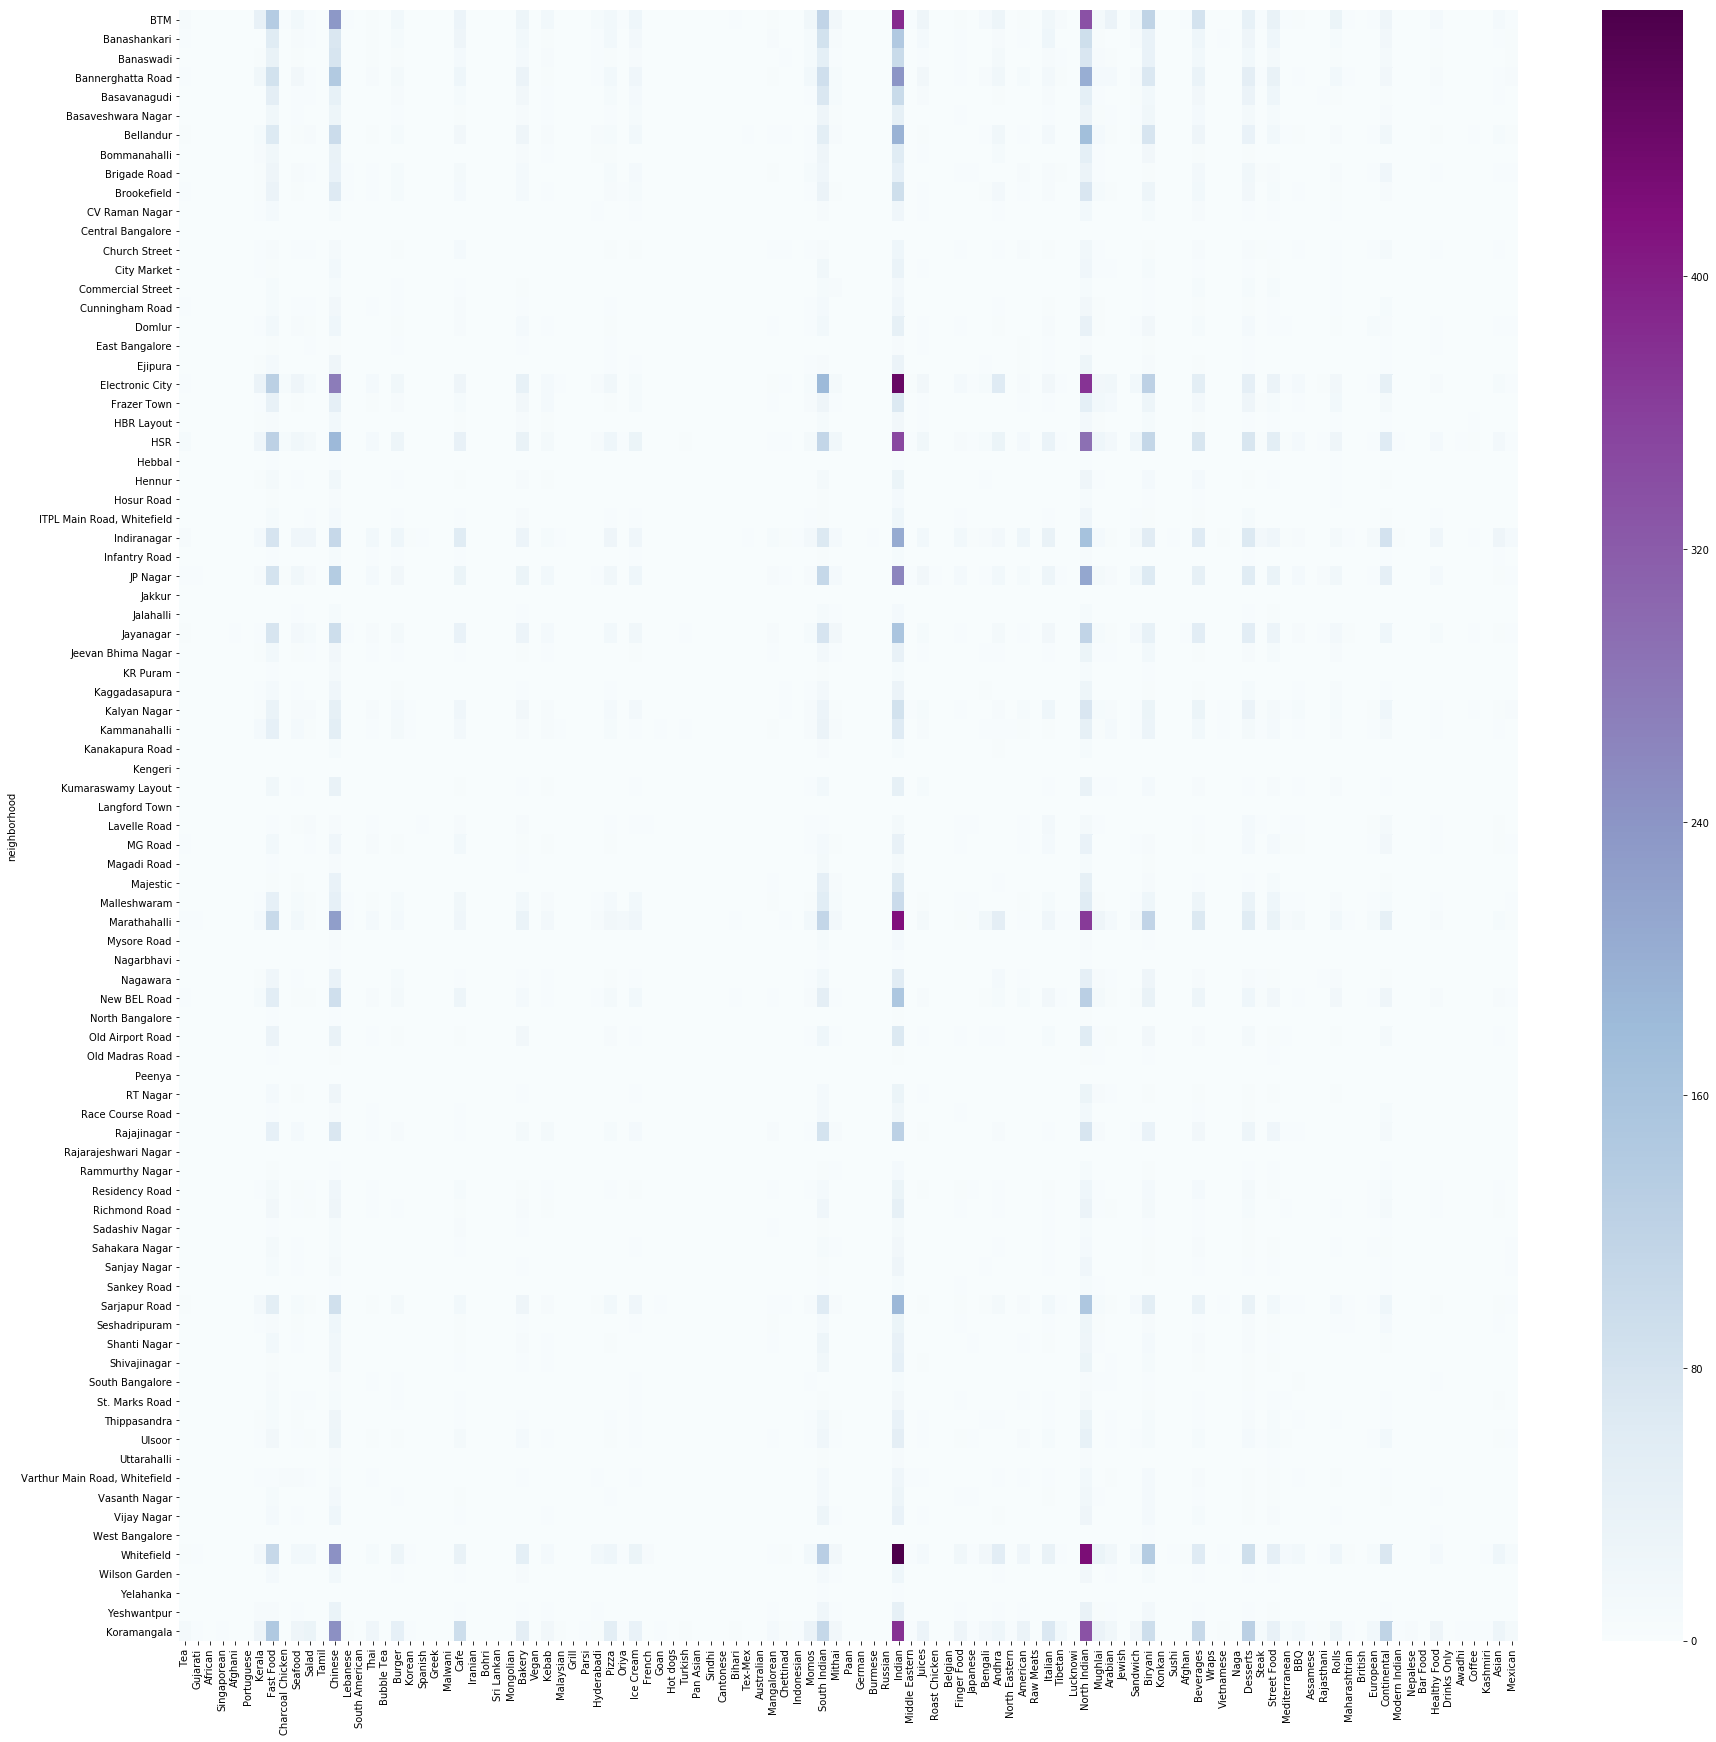

In [340]:
plt.figure(figsize=(30,30))
sns.heatmap(neighborhood_cns,cmap="BuPu")

So can we say, an area becomes more famous as a particular specififc type of cuisine/restaurant increases over there

#### Top 15 Cuisines Of Bengaluru

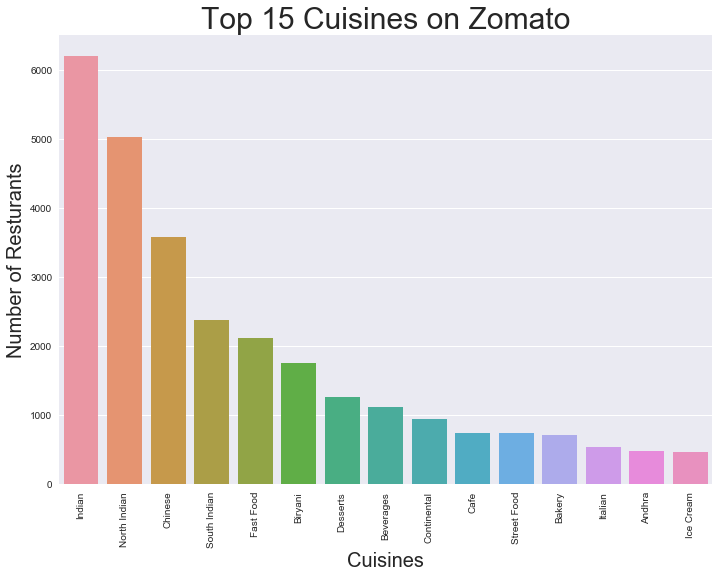

In [333]:

Cuisine_data = pd.DataFrame(neighborhood_cns.sum(axis=0))
Cuisine_data.reset_index(inplace=True)
Cuisine_data.columns = ['Cuisines', 'Number of Resturants']
Top15= (Cuisine_data.sort_values(['Number of Resturants'],ascending=False)).head(15)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(Top15['Cuisines'], Top15['Number of Resturants'])
plt.xlabel('Cuisines', fontsize=20)
plt.ylabel('Number of Resturants', fontsize=20)
plt.title('Top 15 Cuisines on Zomato', fontsize=30)
plt.xticks(rotation = 90)
plt.show()

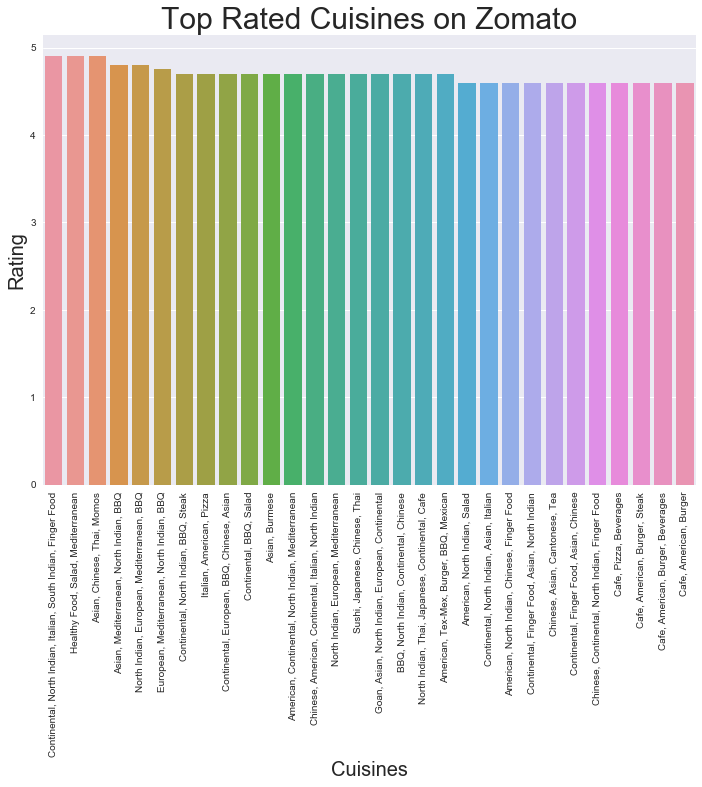

In [342]:
Cuisine_data_rating=(rest_df.groupby(['cuisines'], as_index=False)['rate'].mean())
Cuisine_data_rating.columns = ['Cuisines', 'Rating']
Top30_ratings= (Cuisine_data_rating.sort_values(['Rating'],ascending=False)).head(30)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(Top30_ratings['Cuisines'], Top30_ratings['Rating'])
plt.title('Top Rated Cuisines on Zomato', fontsize=30)
plt.xlabel('Cuisines', fontsize=20)
plt.ylabel('Rating', fontsize=20)
plt.xticks(rotation = 90)
plt.show()

## Types Of Restaurant

In [240]:
listed = rest_df['listed_in(type)'].unique()
column_names = list(listed)
# instantiate the dataframe
neighborhood_lst = pd.DataFrame(columns=column_names)
neighborhood_lst

Empty DataFrame
Columns: [Buffet, Cafes, Delivery, Desserts, Dine-out, Drinks & nightlife, Pubs and bars]
Index: []

In [241]:
neighborhood_lst['neighborhood'] = rest_df.groupby('location').groups.keys()
neighborhood_lst = neighborhood_lst.set_index('neighborhood').fillna(0)
neighborhood_lst

Buffet  Cafes  Delivery  Desserts  Dine-out  \
neighborhood                                                                 
BTM                                 0      0         0         0         0   
Banashankari                        0      0         0         0         0   
Banaswadi                           0      0         0         0         0   
Bannerghatta Road                   0      0         0         0         0   
Basavanagudi                        0      0         0         0         0   
Basaveshwara Nagar                  0      0         0         0         0   
Bellandur                           0      0         0         0         0   
Bommanahalli                        0      0         0         0         0   
Brigade Road                        0      0         0         0         0   
Brookefield                         0      0         0         0         0   
CV Raman Nagar                      0      0         0         0         0   
Central Bangalore                   0      0         0         0         0   
Church Street                       0      0         0         0         0   
City Market                         0      0         0         0         0   
Commercial Street                   0      0         0         0         0   
Cunningham Road                     0      0         0         0         0   
Domlur                              0      0         0         0         0   
East Bangalore                      0      0         0         0         0   
Ejipura                             0      0         0         0         0   
Electronic City                     0      0         0         0         0   
Frazer Town                         0      0         0         0         0   
HBR Layout                          0      0         0         0         0   
HSR                                 0      0         0         0         0   
Hebbal                              0      0         0         0         0   
Hennur                              0      0         0         0         0   
Hosur Road                          0      0         0         0         0   
ITPL Main Road, Whitefield          0      0         0         0         0   
Indiranagar                         0      0         0         0         0   
Infantry Road                       0      0         0         0         0   
JP Nagar                            0      0         0         0         0   
Jakkur                              0      0         0         0         0   
Jalahalli                           0      0         0         0         0   
Jayanagar                           0      0         0         0         0   
Jeevan Bhima Nagar                  0      0         0         0         0   
KR Puram                            0      0         0         0         0   
Kaggadasapura                       0      0         0         0         0   
Kalyan Nagar                        0      0         0         0         0   
...                               ...    ...       ...       ...       ...   
Marathahalli                        0      0         0         0         0   
Mysore Road                         0      0         0         0         0   
Nagarbhavi                          0      0         0         0         0   
Nagawara                            0      0         0         0         0   
New BEL Road                        0      0         0         0         0   
North Bangalore                     0      0         0         0         0   
Old Airport Road                    0      0         0         0         0   
Old Madras Road                     0      0         0         0         0   
Peenya                              0      0         0         0         0   
RT Nagar                            0      0         0         0         0   
Race Course Road                    0      0         0         0         0   
Rajajinagar                         0      0         

In [242]:
i=0
for i in range(0,len(rest_df)):
    for x in listed:
        if type(rest_df.loc[i, 'listed_in(type)']) == str and x in rest_df.loc[i, 'listed_in(type)'] and type(rest_df.loc[i, 'location']) == str:
            neighborhood_lst.loc[rest_df.loc[i, 'location'], x] = neighborhood_lst.loc[rest_df.loc[i, 'location'], x]+1

In [243]:
# Koramangala is divided into different block, lets combine them all
koramangala = ['Koramangala', 'Koramangala 1st Block', 'Koramangala 2nd Block', 'Koramangala 3rd Block', 'Koramangala 4th Block', 
'Koramangala 5th Block', 'Koramangala 6th Block', 'Koramangala 7th Block', 'Koramangala 8th Block']
koramangala_dict = dict(neighborhood_lst.loc[koramangala].sum())
neighborhood_lst = neighborhood_lst.drop(koramangala)
neighborhood_lst.loc['Koramangala'] = koramangala_dict

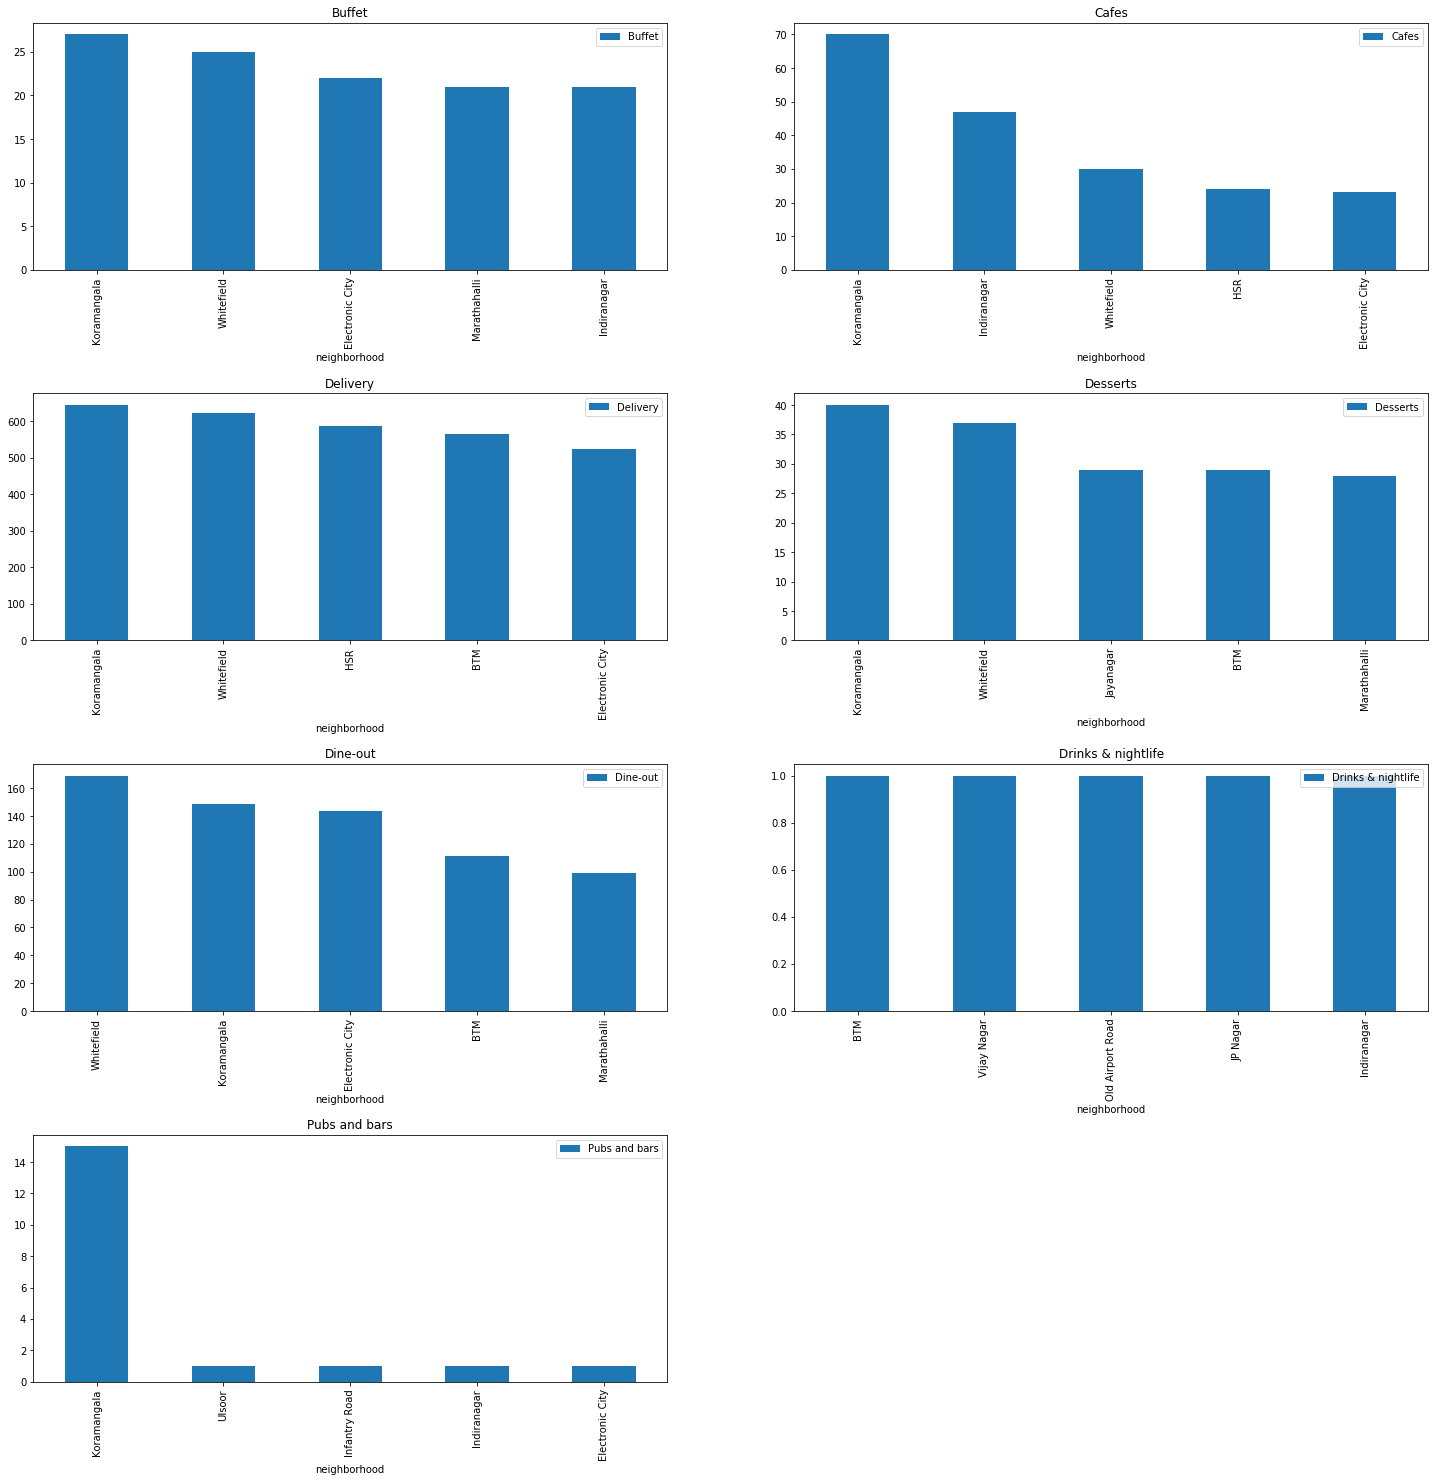

In [307]:
category = neighborhood_lst.columns
fig, ax = plt.subplots(nrows=4, ncols=2, figsize = (25,25))
fig.delaxes(ax[3,1])

plt.subplots_adjust(wspace=0.2, hspace=0.5)
ax = ax.flatten()

for i in range(0,len(category)):
    d= neighborhood_lst[[category[i]]].sort_values(by=category[i], ascending=False).head()
    d.plot(ax=ax[i],kind='bar')
    ax[i].set_title(category[i])
    ax[i].set_xticklabels(d.index, rotation='vertical')
    
plt.show()

Clearly Koramangala has most number of Pubs and bars, With whitefield having the most number of Dine out restaurant, Koramangala with high number of Desserts restaurant, again koramangala and whitefield with large number of delivery restaurant, Koramangala and Indira nagar with large number of Cafes and Koramangala and Whittefield with higher buffet restaurants than others.

It may not be wrong to conclude Koramangala as the hub of restaurants in Bengaluru.

## Rating

#### Restaurant rating Normal Distribution

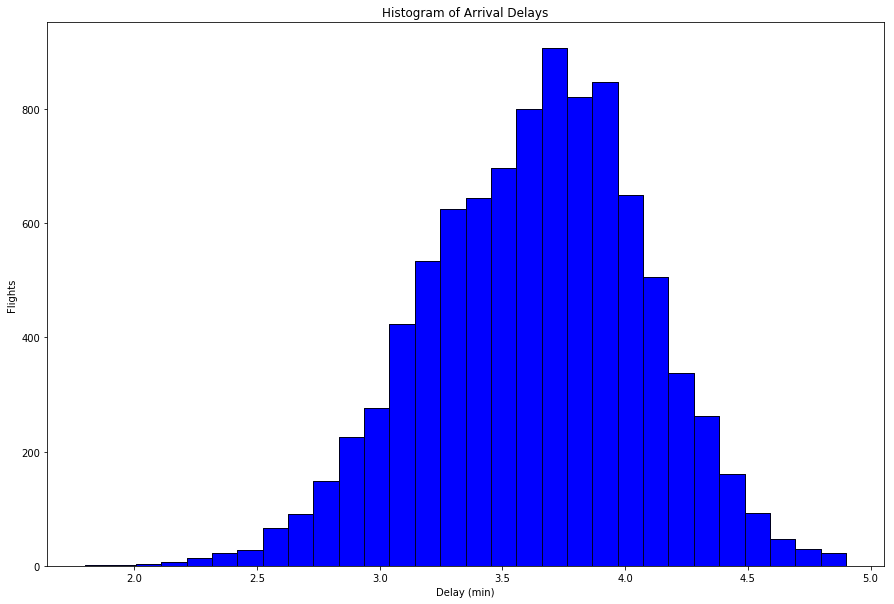

In [156]:
### Restaurant rating distibution
data = rest_df['rate'].dropna()
# matplotlib histogram
plt.figure(figsize=(15,10))
plt.hist(data, color = 'blue', edgecolor = 'black',
         bins = 30)

# seaborn histogram
sns.distplot(data, hist=True, kde=False 
             , color = 'blue',
             bins = 30,
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Arrival Delays')
plt.xlabel('Delay (min)')
plt.ylabel('Flights')

In general, the rating distribution is not normal but in the highest score 3.7 has peak! We have to carefully see the condition of the highest rated restuarant

In [162]:
rest_df[rest_df['rate'] >= 4.8]

url  \
1994   https://www.zomato.com/bangalore/brahmins-coff...   
2087   https://www.zomato.com/bangalore/the-black-pea...   
2242   https://www.zomato.com/bangalore/byg-brewski-b...   
3036   https://www.zomato.com/bangalore/belgian-waffl...   
3917   https://www.zomato.com/bangalore/abs-absolute-...   
3918   https://www.zomato.com/bangalore/flechazo-whit...   
4269   https://www.zomato.com/bangalore/punjab-grill-...   
4906   https://www.zomato.com/bangalore/abs-absolute-...   
4917   https://www.zomato.com/bangalore/asia-kitchen-...   
5474   https://www.zomato.com/bangalore/belgian-waffl...   
5916   https://www.zomato.com/bangalore/house-of-comm...   
7425   https://www.zomato.com/bangalore/belgian-waffl...   
8302   https://www.zomato.com/bangalore/the-pizza-bak...   
8512   https://www.zomato.com/bangalore/milano-ice-cr...   
9014   https://www.zomato.com/bangalore/belgian-waffl...   
10288  https://www.zomato.com/bangalore/chilis-americ...   
10301  https://www.zomato.com/bangalore/punjab-grill-...   
10696  https://www.zomato.com/bangalore/o-g-variar-so...   
10864  https://www.zomato.com/bangalore/abs-absolute-...   
10865  https://www.zomato.com/bangalore/the-globe-gru...   
11142  https://www.zomato.com/bangalore/the-boozy-gri...   
11612  https://www.zomato.com/bangalore/sant%C3%A9-sp...   

                                                 address  \
1994   Ranga Rao Road, Near Shankar Mutt, Shankarapur...   
2087   20/7, Swamy Legato, Outer Ring Road, Kadubeesa...   
2242          Behind MK Retail, Sarjapur Road, Bangalore   
3036   65, Markham Road, Ashok Nagar, Brigade Road, B...   
3917   2nd Floor, I20-A2, EPIP Zone, Near Vydehi Hosp...   
3918   120 A3, 2nd Floor, Santosh Tower, EPIP Industr...   
4269   Ground Floor, Forum Shantiniketan, Whitefield ...   
4906   100 Feet Road, 1st Phase, Near Jayadeva Flyove...   
4917   136, Ground Floor, 1st Cross, 5th Block, Jyoti...   
5474   13 KHB Colony, 17th Main, M.I.G, Koramangala 5...   
5916   122/B, Jyothi Nivas Road, 5th Block, Koramanga...   
7425                            Vasanth Nagar, Bangalore   
8302   2985, 12th Main, HAL 2nd Stage, Indiranagar, B...   
8512   460, 2nd Cross, Krishna Temple Road, Indiranag...   
9014   5M/406, Ground Floor, 2nd Block extension, Hen...   
10288  2nd Floor, Orion Mall, Dr. Rajkumar Road, Mall...   
10301  26/1, Dr Rajkumar Road, Brigade Gateway Campus...   
10696       12th Main, 2nd Block, Rajajinagar, Bangalore   
10864  90/4, 3rd Floor, Outer Ring Road, Munnekollaly...   
10865  2nd Floor, Soul Space Paradigm, Above Bata Sho...   
11142  20/7, 4th & 5th Floor, Swamy Legato, Outer Rin...   
11612  151, 2nd Cross, Domlur 2nd Stage, Indiranagar,...   

                                 name online_order book_table  rate    votes  \
1994             Brahmin's Coffee Bar           No         No   4.8   2679.0   
2087                  The Black Pearl           No        Yes   4.8   7023.0   
2242      Byg Brewski Brewing Company          Yes        Yes   4.9  16345.0   
3036           Belgian Waffle Factory          Yes         No   4.9   1746.0   
3917        AB's - Absolute Barbecues           No        Yes   4.8   2882.0   
3918                         Flechazo           No        Yes   4.9   2745.0   
4269                     Punjab Grill          Yes         No   4.9    518.0   
4906        AB's - Absolute Barbecues           No        Yes   4.9   6375.0   
4917   Asia Kitchen By Mainland China          Yes        Yes   4.9   2178.0   
5474           Belgian Waffle Factory          Yes         No   4.8    186.0   
5916                 House Of Commons           No        Yes   4.8   4390.0   
7425           Belgian Waffle Factory          Yes         No   4.8    392.0   
8302                 The Pizza Bakery          Yes        Yes   4.8   1724.0   
8512                 Milano Ice Cream           No         No   4.9   2090.0   
9014           Belgian Waffle Factory          Yes         No   4.8    265.0   
10288    Ch

Most of the High rated restaurants had North Indian Cuisine in their menu, moreover we can see that all the higher rated restaurant has higher cost of food too. However location does not play much important role here.

### Price range and rating

In [237]:
# Now lets plot box plot based on the cost of food
bins = pd.IntervalIndex.from_tuples([(0, 500), (501, 1000), (1001, 2000), (2001, 3000), (3001, 4000), (4001, 5000), (5001, 6000)])
rest_df['cost_cat'] = pd.cut(rest_df['approx_cost(for two people)'], bins)


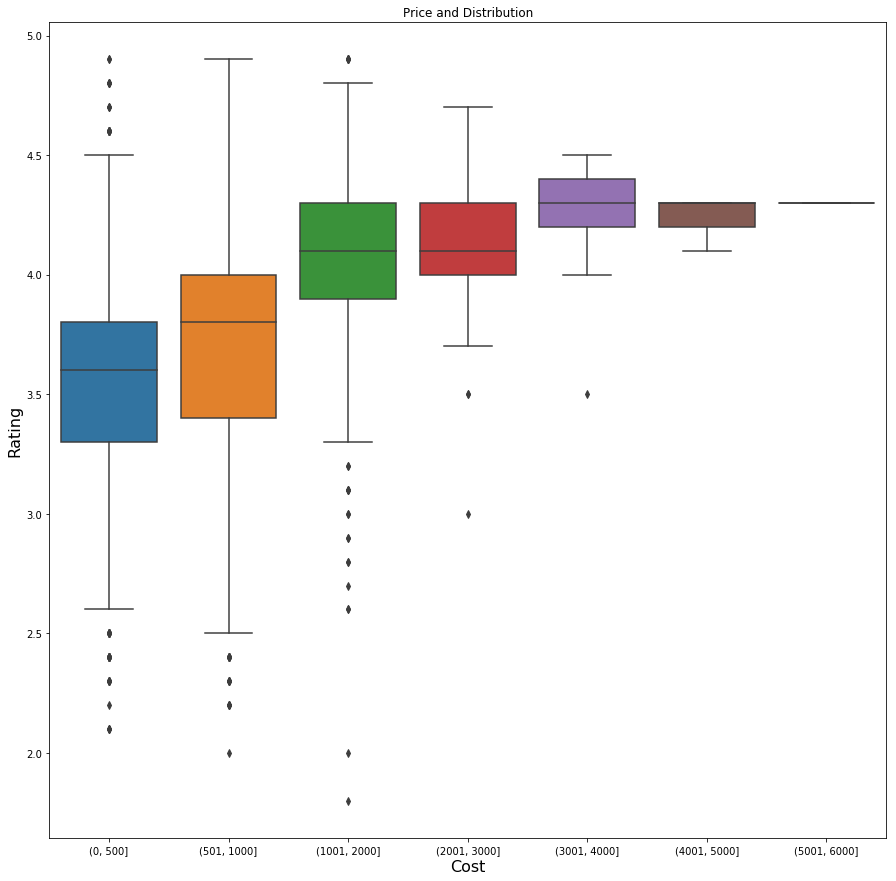

In [238]:
plt.figure(figsize=(15,15))
ax = sns.boxplot(x="cost_cat", y="rate", data=rest_df)
ax.set_xlabel('Cost', fontsize=16)
ax.set_ylabel('Rating', fontsize=16)
ax.set_title('Price and Distribution')
plt.savefig("box.png")
rest_df.drop('cost_cat', axis=1, inplace=True)

It can be seen that as the price increases the average rating of restaurants also increase. So can we say Price does affect rating of a restaurant.?
Not now, there may be some other factors too. lets find out

## Cuisine

#### Cuisine  and rating of a resaurant
Does having more number of cuisine mean higher rating of the restaurant

In [44]:
def fun(x):
    if(type(x) == list):
        return (len(x))
    else:
        return 0
rest_df['no_of_cuisine'] = rest_df['cuisines'].str.split(',').apply(fun)


In [49]:
rest_df.groupby(['no_of_cuisine'])['rate'].mean()

no_of_cuisine
0    3.400000
1    3.584998
2    3.589250
3    3.620158
4    3.736189
5    3.790373
6    3.917822
7    3.905357
8    3.768571
Name: rate, dtype: float64

In [52]:
rest_df.drop('no_of_cuisine', axis=1, inplace=True)

Yes it can be seen that retaurants having more number of cuisines are rated higher

#### So is there a particular cuisine in a restaurant that makes the restaurant rated higher

In [61]:
cuisine = set()
def func(x):
    if(type(x) == list):
        for y in x:
            cuisine.add(y.strip())
_ = rest_df['cuisines'].str.split(',').apply(func)

In [ ]:
cui_df = rest_df[['name', 'location', 'rate', 'cuisines']]
column_names = list(cuisine)
# instantiate the dataframe
cui_df = pd.concat([cui_df, pd.DataFrame(columns=column_names)], axis=1)
cui_df.loc[:, ~cui_df.columns.isin(['name', 'location', 'rate', 'cuisines'])] = cui_df.loc[:, ~cui_df.columns.isin(['name', 'location', 'rate', 'cuisines'])].fillna(0)
cui_df

In [84]:
for i in range(0, len(cui_df)):
    for x in cuisine:
        if type(cui_df.loc[i, 'cuisines']) == str and x in cui_df.loc[i, 'cuisines']:
            cui_df.loc[i, x] = cui_df.loc[i, x]+1

In [99]:
def set_pandas_options() -> None:
    pd.options.display.max_columns = 20
    pd.options.display.max_rows = 75
    pd.options.display.max_colwidth = 199
    pd.options.display.width = None
    # pd.options.display.precision = 2  # set as needed

set_pandas_options()

In [95]:
cui_df.groupby('rate').sum().tail(10).T

rate              4.0  4.1  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9
Goan                1    2    2    0    1    0    0    1    0    0
Seafood            19   29   19    8   12    5    2    0    0    0
Korean              2    5    4    1    5    1    1    0    0    0
North Indian      225  178  110   78   63   31   13   14    5    5
African             0    0    0    1    0    0    2    0    0    0
Bakery             41   24   16   15    2    0    1    0    1    0
Chinese           162  117   65   41   34   17   10    5    0    1
Continental        79   91   76   58   39   26    8   11    3    1
Australian          0    0    0    0    0    0    0    0    0    0
Thai               24   15   11   11   11    7    2    2    0    1
Sushi               1    1    0    0    0    1    0    1    0    0
South Indian       88   64   33   35   13    9    3    2    1    1
South American      0    1    0    0    0    0    0    0    0    0
Sindhi              0    0    1    0    0    0    0    0    0    0
Ice Cream          28   28   15   16   12   13    3    1    0    1
Portuguese          0    1    0    1    0    0    0    0    0    0
Naga                2    0    0    1    0    0    0    0    0    0
Jewish              0    0    0    1    0    0    0    0    0    0
Turkish             2    3    2    4    0    1    0    0    0    0
Bubble Tea          0    1    0    0    0    0    0    0    0    0
Rajasthani          4    3    2    3    0    0    0    0    0    0
BBQ                 7    6   11   10    7    5    3   10    4    2
Sandwich           18   12   10    4    8    3    1    0    0    0
Fast Food         117   67   30   18    9    1    1    0    0    0
Hyderabadi         10    5    0    0    0    0    0    0    0    0
Wraps               0    2    1    0    0    0    0    0    0    0
Greek               1    0    1    0    0    0    0    0    0    0
Biryani            68   36   26   19   12    4    1    0    0    0
Awadhi              0    0    1    0    2    0    0    0    0    0
Momos              21   11   10   16    6    4    0    1    0    1
Andhra             21    8   12    7    3    0    0    0    0    0
Spanish             1    0    2    2    0    0    1    0    0    0
Gujarati            3    1    0    0    0    0    0    0    0    0
Steak              15   13    9    5    1    3    3    3    0    0
Tex-Mex             0    1    0    1    0    1    1    0    1    0
Russian             0    0    1    0    0    0    0    0    0    0
Lebanese            1    1    3    1    0    1    0    0    0    0
Arabian             8    9   10    7    2    0    0    0    0    0
Rolls              17    7    1    1    2    1    0    0    0    0
Healthy Food        9   18    9    9    7    3    1    0    0    1
Malwani             0    0    0    0    0    0    0    0    0    0
Lucknowi            2    0    0    0    0    1    0    0    0    0
Singaporean         0    0    1    1    3    1    1    0    0    0
Desserts           93   76   61   48   29   20   13    2    4    2
Finger Food        10   23   12   20    7    6    5    0    0    1
Chettinad           2    1    2    1    0    0    0    0    0    0
Pizza              36   34   26   28   20   11    5    1    1    0
Vietnamese          7    4    0    2    5    2    1    0    0    0
Modern Indian       2    2    2    3    5    3    0    1    0    0
Hot dogs            0    0    0    0    0    0    0    0    0    0
Italian            52   69   44   41   24   16   10    5    2    1
Maharashtrian       4    3    2    0    0    1    0    0    0    0
Konkan              0    3    1    1    2    1    0    0    0    0
Tea                 4    3    3    1    2    0    1    0    0    0
Mediterranean       6    7   14   10    8    6    2    7    3    3
Afghan              2    3    1    0    0    0    0    0    0    0
Pan Asian           0    0    0    0    0    0    0    0    0    0
Sri Lankan          0    1    0    0    1    0    0    0    0    0
Cantonese           0    0    0    0    0    0 

After analysing the data it was found that these type of cuisines were very highly rated <i>Goa, Seafood, Korean, African,Fast Food, Biryani, Chinese, Continental, Thai, Sushi, Sindhi, Portuguese, Turkish, Naga, Jewish, 
Rajasthani, BBQ, Sandwich, Momos, Andhra, Steak, Tex-Mex, Arabian, Rolls, Healthy Food, Desserts, Finger Food, Pizza, Vietnamese
Italian, Mediterranean, Kebab, American, Japanese, Mexican, Indonesian, Burmese, European, French, Malaysian, Asian, Mughlai, Burger, 
Iranian</i> but among these <b>American, Italian, Pizza, Biryani, Continental, Chinese, Seafood, Korean</b> were much highly rated. Though North Indian, South Indian, Ice Cream, Mangalorean Beverages, Street Food, Cafe, Indian were the top rated but it is quite obvious for such type of restaurant to be at the top.

### Lets find out which neighborhood is famous for what type of cuisine

In [106]:
# Now can we say whcih neighborhood is famous for what type of food or cuisine
cuisine_grouped = cui_df.groupby('location').sum()
cuisine_grouped

rate  Goan  Seafood  Korean  North Indian  \
location                                                                     
BTM                            1842.5     0       16       0           335   
Banashankari                    823.1     0        6       1            93   
Banaswadi                       507.7     0        4       0            74   
Bannerghatta Road              1216.6     0       18       0           200   
Basavanagudi                    650.5     0        3       0            50   
Basaveshwara Nagar              240.9     0        3       0            32   
Bellandur                       904.8     0        4       0           172   
Bommanahalli                    173.8     0        1       0            50   
Brigade Road                    397.0     0        6       1            32   
Brookefield                     499.8     0        5       0            74   
CV Raman Nagar                  101.5     0        1       0            16   
Central Bangalore                 3.7     0        0       0             0   
Church Street                   210.5     0        3       0            20   
City Market                      74.6     0        1       0            21   
Commercial Street               121.2     0        0       0             9   
Cunningham Road                 175.6     0        3       0            18   
Domlur                          260.3     1        6       0            41   
East Bangalore                   48.5     1        0       0             7   
Ejipura                         118.1     0        1       0            27   
Electronic City                1590.3     0       25       0           375   
Frazer Town                     522.9     0        4       0            50   
HBR Layout                       91.6     0        1       0            14   
HSR                            1876.9     0       20       1           292   
Hebbal                           14.4     0        0       0             2   
Hennur                          162.5     0        2       0            25   
Hosur Road                       38.1     0        1       0             9   
ITPL Main Road, Whitefield      121.7     0        0       0            21   
Indiranagar                    1638.1     0       21       4           166   
Infantry Road                    48.8     0        1       1             7   
JP Nagar                       1352.1     0       19       0           211   
Jakkur                            0.0     0        0       0             1   
Jalahalli                        52.2     0        2       0             9   
Jayanagar                      1150.8     0       14       0           116   
Jeevan Bhima Nagar              245.7     0        5       0            30   
KR Puram                         28.4     0        0       0             8   
Kaggadasapura                   174.5     0        2       0            27   
Kalyan Nagar                    702.6     1        7       2            73   
...                               ...   ...      ...     ...           ...   
Marathahalli                   1755.0     0       15       1           366   
Mysore Road                      29.1     0        0       0             7   
Nagarbhavi                        3.4     0        0       0             2   
Nagawara                        297.2     0        3       0            48   
New BEL Road                    801.3     0        5       0           129   
North Bangalore                  13.5     0        0       0             4   
Old Airport Road                392.5     0        1       0            61   
Old Madras Road                  30.2     0        0       0             4   
Peenya                            3.2     0        0       0             1   
RT Nagar                        139.0     0        5       0            30   
Race Course Road                112.0     0        0       0            16   
Rajajinagar                     625.5     0       11   

##### Lets print the top 5 cuisine famous in each of the neighborhood

In [140]:
num_top_venues = 5
for hood in cuisine_grouped.index:
    print("----"+hood+"----")
    temp = cuisine_grouped[cuisine_grouped.index == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----BTM----
          venue   freq
0        Indian  385.0
1  North Indian  335.0
2       Chinese  236.0
3     Fast Food  138.0
4       Biryani  118.0


----Banashankari----
          venue   freq
0        Indian  144.0
1  North Indian   93.0
2  South Indian   85.0
3       Chinese   71.0
4     Fast Food   60.0


----Banaswadi----
          venue   freq
0        Indian  101.0
1       Chinese   77.0
2  North Indian   74.0
3  South Indian   49.0
4     Fast Food   38.0


----Bannerghatta Road----
          venue   freq
0        Indian  239.0
1  North Indian  200.0
2       Chinese  143.0
3  South Indian   91.0
4     Fast Food   85.0


----Basavanagudi----
          venue   freq
0        Indian  101.0
1  South Indian   72.0
2     Fast Food   52.0
3  North Indian   50.0
4       Chinese   42.0


----Basaveshwara Nagar----
          venue  freq
0        Indian  45.0
1  North Indian  32.0
2       Chinese  27.0
3  South Indian  25.0
4       Biryani  19.0


----Bellandur----
          venue   freq


4     Fast Food  16.0


----Magadi Road----
          venue  freq
0        Indian  13.0
1  South Indian  12.0
2  North Indian   8.0
3       Chinese   6.0
4       Biryani   5.0


----Majestic----
          venue  freq
0        Indian  68.0
1  South Indian  48.0
2  North Indian  45.0
3       Chinese  36.0
4   Street Food   9.0


----Malleshwaram----
          venue  freq
0        Indian  99.0
1  North Indian  60.0
2  South Indian  57.0
3       Chinese  43.0
4     Fast Food  43.0


----Marathahalli----
          venue   freq
0        Indian  417.0
1  North Indian  366.0
2       Chinese  226.0
3       Biryani  116.0
4  South Indian  113.0


----Mysore Road----
          venue  freq
0        Indian  11.0
1  South Indian   9.0
2  North Indian   7.0
3       Chinese   6.0
4       Biryani   3.0


----Nagarbhavi----
          venue  freq
0        Indian   3.0
1       Chinese   3.0
2  South Indian   3.0
3  North Indian   2.0
4   Street Food   1.0


----Nagawara----
          venue  freq
0        

#### Cuisine popular in Bengaluru

In [ ]:
from subprocess import check_output
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = (WordCloud(width=1440, height=1080, relative_scaling=0.5).generate_from_frequencies(cuisine_grouped.iloc[:,1:].sum()))

fig = plt.figure(1,figsize=(15, 15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<img src="https://i.ibb.co/kXXNq2S/cuisine.png" alt="wordcloud" height="1500" width="1500">

#### Rating and Cuisine
#### Is there any cuisine which is always rated high

In [156]:
cui_df
# Now lets plot box plot based on the cost of food
bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)])
cui_df['rate_cat'] = pd.cut(cui_df['rate'], bins)
cui_df['rate_cat'] = cui_df['rate_cat'].astype(str)
cui_df['rate_cat'] = cui_df['rate_cat'].map({'(0.0, 1.0]' : 1, '(1.0, 2.0]' : 2, '(2.0, 3.0]' : 3, '(3.0, 4.0]' : 4, '(4.0, 5.0]' : 5 })

In [158]:
ra_cu = cui_df.groupby(['rate_cat']).sum()
ra_cu

rate  Goan  Seafood  Korean  North Indian  African  Bakery  \
rate_cat                                                                  
2.0           5.8     0        0       0             2        0       0   
3.0        2489.5     0       23       0           482        0      37   
4.0       24959.4     7      222       5          2870        0     397   
5.0        6202.8     6       75      17           497        3      59   

          Chinese  Continental  Australian  ...  Burger  Tamil  Tibetan  \
rate_cat                                    ...                           
2.0             2            1           0  ...       0      0        0   
3.0           394           35           0  ...      30      0        6   
4.0          2147          459           1  ...     250      3       42   
5.0           290          313           0  ...      85      0        6   

          Middle Eastern  Nepalese  Assamese  Indian  Kashmiri  Roast Chicken  \
rate_cat                                                                        
2.0                    0         0         0       2         0              0   
3.0                    1         0         0     526         0              0   
4.0                   11         6         2    3471         7              9   
5.0                    4         3         1     594         0              0   

          Iranian  
rate_cat           
2.0             0  
3.0             0  
4.0             3  
5.0             1  

[4 rows x 108 columns]

----2.0----
        cuisine  freq
0       Chinese   2.0
1  North Indian   2.0
2        Indian   2.0
3        Andhra   1.0
4  South Indian   1.0


----3.0----
        cuisine   freq
0        Indian  526.0
1  North Indian  482.0
2       Chinese  394.0
3     Fast Food  183.0
4       Biryani  155.0


----4.0----
        cuisine    freq
0        Indian  3471.0
1  North Indian  2870.0
2       Chinese  2147.0
3  South Indian  1323.0
4     Fast Food  1288.0


----5.0----
        cuisine   freq
0        Indian  594.0
1  North Indian  497.0
2   Continental  313.0
3       Chinese  290.0
4      Desserts  255.0




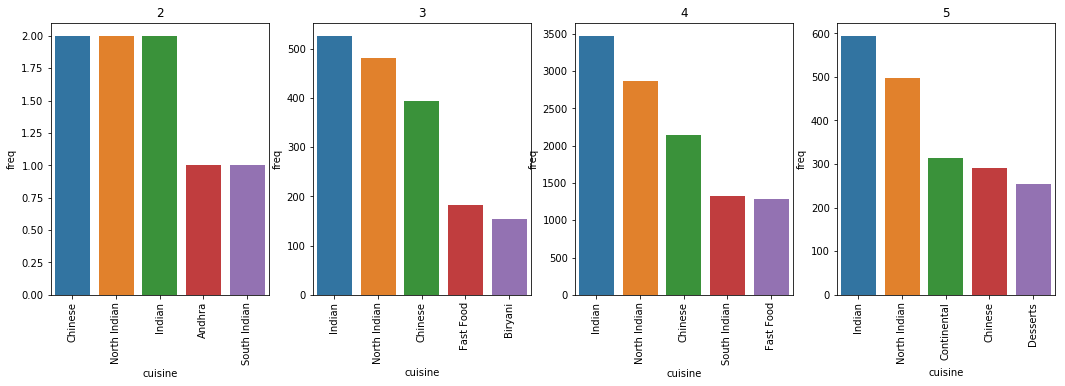

In [235]:
num_top_venues = 5
f, ax = plt.subplots(1,4, figsize = (18,5))
i = 2
for hood in ra_cu.index:
    print("----"+str(hood)+"----")
    temp = ra_cu[ra_cu.index == hood].T.reset_index()
    temp.columns = ['cuisine','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
    sns.barplot(y = 'freq', x = 'cuisine', data = temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues), ax = ax[i-2],)
    ax[i-2].set_title(str(i))
    ax[i-2].set_xticklabels(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues).cuisine, rotation='vertical')
    i+=1
plt.show()

Indian, North Indian, Chinese tough were common among the ratings but Most of the continental Cuisine restaurant were rated high which was also evident from the data, and not to forget there are large number of desserts restaurant

# Statistical Analysis

In [167]:
import statsmodels.formula.api as smf

### Are ratings affected by how cheap/expensive a restaurant is ?


In [233]:
data = [
    go.Scatter(x = rest_df['approx_cost(for two people)'],
              y = rest_df['rate'],
              mode = "markers",
               text = rest_df['name'],
               marker = dict(opacity = 0.7,
                            size = 10,
                            color = rest_df['rate'], #Set color equalivant to rating
                            colorscale= 'Viridis',
                            showscale=True,
                             maxdisplayed=2500,
                            ),
                hoverinfo="text+x+y",
              )
]
layout = go.Layout(autosize=True,
                   xaxis=dict(title="Average Cost of Two (INR)",
                             #titlefont=dict(size=20,),
                             #tickmode="linear",
                             ),
                   yaxis=dict(title="Rating",
                             #titlefont=dict(size=17,),
                             ),
                  )
iplot(dict(data=data, layout=layout))

As it seems, from a quick glance, there is no obseravable linear relationship. At almost every price point, there appears to be both Good and Bad restaurants.

Not wasting our time further lets carry out statistical analysis pearson correlation on it.<br>
<b>Null Hypothesis</b> : There is no relationship between the rating and price of the restaurant<br>
<b>Alternate Hypothesis</b> : There is some relationship between the two


In [375]:
pear = rest_df.dropna(subset=['approx_cost(for two people)', 'rate'])

In [379]:
from scipy import stats 
pearson_coef, p_value = stats.pearsonr(pear['approx_cost(for two people)'], pear['rate']) 
print("Pearson Correlation Coefficient: ", pearson_coef, "and a P-value of:", p_value) # Results 

Pearson Correlation Coefficient:  0.32609607011051456 and a P-value of: 3.595009214519809e-228


The p-values comes out to be much much lower than our signifiance level. Hence we reject our NULL hypothesis and accept the alternate hypothesis. And our finding can be said to be statistically significant.
Therefore we can say that there is some relationship between the two.

As it seems, from a quick glance, there is no obseravable linear relationship. At almost every price point, there appears to be both low and high cost restaurants.

Lets carry out the statistical analysis

<b>Null Hypothesis</b> : There is no relationship between the rating and votes of the restaurant<br>
<b>Alternate Hypothesis</b> : There is some relationship between the two


In [383]:
pear = rest_df.dropna(subset=['votes', 'rate'])

In [384]:
pearson_coef, p_value = stats.pearsonr(pear['votes'], pear['rate']) 
print("Pearson Correlation Coefficient: ", pearson_coef, "and a P-value of:", p_value) # Results 

Pearson Correlation Coefficient:  0.39935415986250994 and a P-value of: 0.0


The p-value shows result is significant. And hence we reject our NULL hypothesis and accept the Alternate Hypothesis i.e both the variables are related and our finding was statistically significant

### Are restaurants that offer Table booking option rated higher?

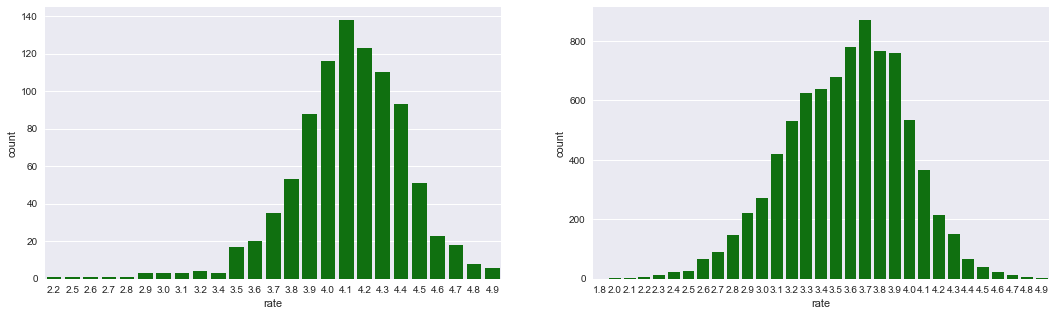

In [420]:
pear = rest_df[rest_df['book_table'] == 'Yes']
f, ax = plt.subplots(1,2, figsize = (18,5))
sns.countplot(pear['rate'], color="g", ax=ax[0])
pear = rest_df[rest_df['book_table'] == 'No']
sns.countplot(pear['rate'], color="g",  ax=ax[1])
plt.show()

In [424]:
model = smf.ols(formula='rate ~ C(book_table)', data=rest_df).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                   rate   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     1526.
Date:                Mon, 22 Apr 2019   Prob (F-statistic):          3.39e-309
Time:                        20:59:06   Log-Likelihood:                -4663.8
No. Observations:                9285   AIC:                             9332.
Df Residuals:                    9283   BIC:                             9346.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.5712 

Yes, The relation is statistically significant

## Now Lets see the top venues of each areas of Bangalore 
These are venues with the highest foot traffic at the time this regular call to the API is made. So at what time restaurants are more famous

In [4]:
import requests
from pandas.io.json import json_normalize

In [5]:
CLIENT_ID = 'WPTSXRBGDLUULN1OWDRCQUAE3KIEDUNMQM5AW5Q0DH5UCCAY' # your Foursquare ID
CLIENT_SECRET = 'TR4030IUWOWEHNIZCT0EQGVC2BMLZV35KSHH404AAWSMFXAU' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
radius = 9999

In [6]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [25]:
neigh_lat_lon = rest_df.groupby(['location'])['location_latitude', 'location_longitude'].first()
neigh_lat_lon

location_latitude  location_longitude
location                                                            
BTM                                    12.911276           77.604565
Banashankari                           12.915382           77.573638
Banaswadi                              13.014162           77.651854
Bannerghatta Road                      12.920579           77.600117
Basavanagudi                           12.941726           77.575502
Basaveshwara Nagar                     12.993224           77.539158
Bellandur                              12.979120           77.591300
Bommanahalli                           12.908945           77.623904
Brigade Road                           12.973613           77.607472
Brookefield                            12.961570           77.709180
CV Raman Nagar                         12.980300           77.651990
Central Bangalore                      12.979120           77.591300
Church Street                          12.975200           77.604141
City Market                            12.965718           77.576271
Commercial Street                      12.982193           77.608313
Cunningham Road                        12.986891           77.595030
Domlur                                 12.962467           77.638196
East Bangalore                         12.979120           77.591300
Ejipura                                12.945245           77.626914
Electronic City                        12.836290           77.657580
Frazer Town                            12.996845           77.613017
HBR Layout                             13.035870           77.632360
HSR                                    12.914453           77.642694
Hebbal                                 13.038218           77.591900
Hennur                                 13.025809           77.630507
Hosur Road                             12.929565           77.615163
ITPL Main Road, Whitefield             12.967576           77.715088
Indiranagar                            12.973291           77.640467
Infantry Road                          12.983177           77.595831
JP Nagar                               12.907251           77.578271
...                                          ...                 ...
Old Madras Road                        13.007609           77.690023
Peenya                                 13.032942           77.527325
RT Nagar                               13.022720           77.595715
Race Course Road                       12.980696           77.577429
Rajajinagar                            12.988234           77.554883
Rajarajeshwari Nagar                   12.927428           77.515372
Rammurthy Nagar                        13.031010           77.675110
Residency Road                         13.053000           77.620483
Richmond Road                          12.966260           77.606716
Sadashiv Nagar                         13.007050           77.578840
Sahakara Nagar                         13.062147           77.580061
Sanjay Nagar                           12.957866           77.695875
Sankey Road                            12.989950           77.585838
Sarjapur Road                          12.924484           77.650272
Seshadripuram                          12.993188           77.575342
Shanti Nagar                           12.957555           77.597910
Shivajinagar                           12.986391           77.607542
South Bangalore                        12.979120           77.591300
St. Marks Road                         12.977906           77.602201
Thippasandra                           12.973936           77.650998
Ulsoor                                 12.977879           77.624670
Uttarahalli                            12.905568           77.545544
Varthur Main Road, Whitefield          12.941466           77.747094
Vasanth Nagar                          12.988721           77.585169
Vijay Nagar                            12.966274           77.612705
West Bangalore               

In [52]:
column_names = ['cat1', 'cat2', 'cat3', 'cat4', 'cat5']
# instantiate the dataframe
df = pd.DataFrame(columns=column_names)
df

Empty DataFrame
Columns: [cat1, cat2, cat3, cat4, cat5]
Index: []

In [ ]:
i=0
for lat, long in zip(neigh_lat_lon.location_latitude, neigh_lat_lon.location_longitude):
    latitude = lat
    longitude = long
    # define URL
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    # send GET request and get trending venues
    results = requests.get(url).json()
    items = results['response']['groups'][0]['items']
    
    dataframe = json_normalize(items) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # filter the category for each row
    dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean columns
    dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

    print(neigh_lat_lon.index[i], " : ",dataframe_filtered.head(5)['categories'])
    df.loc[neigh_lat_lon.index[i]] = dataframe_filtered.head(5)['categories'].tolist()
    i+=1
    

In [57]:
df

cat1  \
BTM                                            Ice Cream Shop   
Banashankari                                      Pizza Place   
Banaswadi                                      Ice Cream Shop   
Bannerghatta Road                           Indian Restaurant   
Basavanagudi                                Indian Restaurant   
Basaveshwara Nagar                             Ice Cream Shop   
Bellandur                                                Park   
Bommanahalli                                     Burger Joint   
Brigade Road                                          Brewery   
Brookefield                                    Ice Cream Shop   
CV Raman Nagar                                        Brewery   
Central Bangalore                                        Park   
Church Street                             American Restaurant   
City Market                                    Breakfast Spot   
Commercial Street                         American Restaurant   
Cunningham Road                                      Tea Room   
Domlur                                         Ice Cream Shop   
East Bangalore                                           Park   
Ejipura                                  Fast Food Restaurant   
Electronic City                Multicuisine Indian Restaurant   
Frazer Town                                               Pub   
HBR Layout                                     Ice Cream Shop   
HSR                                            Ice Cream Shop   
Hebbal                                           Burger Joint   
Hennur                                         Ice Cream Shop   
Hosur Road                                       Burger Joint   
ITPL Main Road, Whitefield                            Brewery   
Indiranagar                                           Brewery   
Infantry Road                                        Tea Room   
JP Nagar                                          Snack Place   
Jakkur                                                Brewery   
Jalahalli                                  Italian Restaurant   
Jayanagar                                      Sandwich Place   
Jeevan Bhima Nagar                                      Hotel   
KR Puram                                        Shopping Mall   
Kaggadasapura                                   Shopping Mall   
Kalyan Nagar                                   Ice Cream Shop   
Kammanahalli                                    Shopping Mall   
Kanakapura Road                                   Snack Place   
Kengeri                                                  Café   
Koramangala                                      Burger Joint   
Koramangala 1st Block                       Mobile Phone Shop   
Koramangala 2nd Block                            Burger Joint   
Koramangala 3rd Block                       Mobile Phone Shop   
Koramangala 4th Block                    Fast Food Restaurant   
Koramangala 5th Block                            Burger Joint   
Koramangala 6th Block                            Burger Joint   
Koramangala 7th Block                            Burger Joint   
Koramangala 8th Block                            Burger Joint   
Kumaraswamy Layout                                Pizza Place   
Langford Town                                    Cocktail Bar   
Lavelle Road                              American Restaurant   
MG Road                                               Brewery   
Magadi Road                                    Ice Cream Shop   
Majestic                                       Ice Cream Shop   
Malleshwaram                                Indian Restaurant   
Marathahalli                                   Ice Cream Shop   
Mysore Road                                    Breakfast Spot   
Nagarbhavi                                     Ice Cream Shop   
Nagawara                                       Ice Cream Shop   
New BEL Road                                     Burger Joint   
North Bangalore            

# Cluster Neighborhoods

### Clustering on the basis of cuisine

In [169]:
## Now lets use ML to cluster neighborhoods by their food style
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [190]:
cuisine = set()
def func(x):
    if(type(x) == list):
        for y in x:
            cuisine.add(y.strip())
_ = rest_df['cuisines'].str.split(',').apply(func)
cui_df = rest_df[['name', 'location', 'rate', 'cuisines']]
column_names = list(cuisine)
# instantiate the dataframe
cui_df = pd.concat([cui_df, pd.DataFrame(columns=column_names)], axis=1)
cui_df.loc[:, ~cui_df.columns.isin(['name', 'location', 'rate', 'cuisines'])] = cui_df.loc[:, ~cui_df.columns.isin(['name', 'location', 'rate', 'cuisines'])].fillna(0)
cui_df

name  \
0                                                  Jalsa   
1                                         Spice Elephant   
2                                        San Churro Cafe   
3                                  Addhuri Udupi Bhojana   
4                                          Grand Village   
5                                        Timepass Dinner   
6        Rosewood International Hotel - Bar & Restaurant   
7                                                 Onesta   
8                                         Penthouse Cafe   
9                                              Smacznego   
10                                   Cafe Down The Alley   
11                                          Cafe Shuffle   
12                                      The Coffee Shack   
13                                            Caf-Eleven   
14                                         Cafe Vivacity   
15                                          Catch-up-ino   
16                                      Kirthi's Biryani   
17                                              T3H Cafe   
18                         360 Atoms Restaurant And Cafe   
19                                      The Vintage Cafe   
20                                          Woodee Pizza   
21                                       Cafe Coffee Day   
22                                          My Tea House   
23                                         Hide Out Cafe   
24                                             CAFE NOVA   
25                                          Coffee Tindi   
26                                        Sea Green Cafe   
27                                                 Cuppa   
28                                      Srinathji's Cafe   
29                                             Redberrys   
...                                                  ...   
12436                                       Black Pagoda   
12437                              Noodle And Soup Point   
12438                                           Food Dig   
12439                                          Ishwaryam   
12440                                         Hungry Wok   
12441                                        Get Grilled   
12442                                       Thindi Sante   
12443                                       Hotel Devika   
12444                              Basaveshwara Kanawali   
12445                                    Sri Udupi Grand   
12446                                 SM Bangarpet Chats   
12447                                        Mad Kitchen   
12448                                             V Dine   
12449                                    Polly's Kitchen   
12450                                    The Yellow Stop   
12451                                 Arabian Fame Grill   
12452                                      Roll Junction   
12453                                 Shrawan Restaurant   
12454                        Calcutta North Indian Meals   
12455                                            Chianti   
12456  Chime - Sheraton Grand Bengaluru Whitefield Ho...   
12457                       The Nest - The Den Bengaluru   
12458                                          Chung Wah   
12459                                      Nawabs Empire   
12460                                     Fujian Express   
12461                                 New Shalimar Hotel   
12462        Nook - Aloft Bengaluru Cessna Business Park   
12463                                   SeeYa Restaurant   
12464                                            Bhagini   
12465  Plunge - Sheraton Grand Bengaluru Whitefield H...   

                         location  rate  \
0                    Banashankari   4.1   
1                    Banashankari   4.1   
2                    Banashankari   3.8   
3                    Banashankari   3.7   
4                    Basavanagudi   3.8   
5                    Basavanagudi   3.8   
6                     Mysore R

In [195]:
for i in range(0, len(cui_df)):
    for x in cuisine:
        if type(cui_df.loc[i, 'cuisines']) == str and x in cui_df.loc[i, 'cuisines']:
            cui_df.loc[i, x] = cui_df.loc[i, x]+1

cuisine_grouped = cui_df.groupby('location').sum()
cuisine_grouped.drop('name', axis=1, inplace=True)
cuisine_grouped

South American  Awadhi  Jewish  Hot dogs  \
location                                                                  
BTM                                         0       0       0         0   
Banashankari                                0       0       0         0   
Banaswadi                                   0       0       0         0   
Bannerghatta Road                           0       0       0         0   
Basavanagudi                                0       0       0         0   
Basaveshwara Nagar                          0       0       0         0   
Bellandur                                   0       0       0         0   
Bommanahalli                                0       0       0         0   
Brigade Road                                0       0       0         0   
Brookefield                                 0       0       0         0   
CV Raman Nagar                              0       0       0         0   
Central Bangalore                           0       0       0         0   
Church Street                               0       0       0         0   
City Market                                 0       0       0         0   
Commercial Street                           0       0       0         0   
Cunningham Road                             0       1       0         0   
Domlur                                      0       0       0         0   
East Bangalore                              0       0       0         0   
Ejipura                                     0       0       0         0   
Electronic City                             0       0       0         0   
Frazer Town                                 0       0       0         0   
HBR Layout                                  0       0       1         0   
HSR                                         0       2       0         0   
Hebbal                                      0       0       0         0   
Hennur                                      0       0       0         0   
Hosur Road                                  0       0       0         0   
ITPL Main Road, Whitefield                  0       0       0         0   
Indiranagar                                 0       0       0         1   
Infantry Road                               0       0       0         0   
JP Nagar                                    1       1       0         0   
...                                       ...     ...     ...       ...   
Peenya                                      0       0       0         0   
RT Nagar                                    0       0       0         0   
Race Course Road                            0       0       0         0   
Rajajinagar                                 0       0       0         0   
Rajarajeshwari Nagar                        0       0       0         0   
Rammurthy Nagar                             0       0       0         0   
Residency Road                              1       0       0         0   
Richmond Road                               0       0       0         0   
Sadashiv Nagar                              0       0       0         0   
Sahakara Nagar                              0       0       0         0   
Sanjay Nagar                                0       0       0         0   
Sankey Road                                 0       0       0         0   
Sarjapur Road                               0       0       0         0   
Seshadripuram                               0       0       0         0   
Shanti Nagar                                0       0       0         0   
Shivajinagar                                0       0       0         0   
South Bangalore                             0       0       0         0   
St. Marks Road                              0       0       0         0   
Thippasandra                                0       0       0         0   
Ulsoor                                      0       0       0         0   
Uttarahalli                                 0       0   

In [194]:
# Koramangala is divided into different block, lets combine them all
koramangala = ['Koramangala', 'Koramangala 1st Block', 'Koramangala 2nd Block', 'Koramangala 3rd Block', 'Koramangala 4th Block', 
'Koramangala 5th Block', 'Koramangala 6th Block', 'Koramangala 7th Block', 'Koramangala 8th Block']
koramangala_dict = dict(cuisine_grouped.loc[koramangala].sum())
cuisine_grouped = cuisine_grouped.drop(koramangala)
cuisine_grouped.loc['Koramangala'] = koramangala_dict

name  \
location                                                                           
BTM                            Sankranthi Veg RestaurantHearts Unlock Cafeeat...   
Banashankari                   JalsaSpice ElephantSan Churro CafeAddhuri Udup...   
Banaswadi                      Cafe NibrasThe SanctuaryCrunch Pizzas9 BowlsPi...   
Bannerghatta Road              Deja Vu Resto BarFattoushEmpire RestaurantAbhi...   
Basavanagudi                   Grand VillageTimepass DinnerSrinathji's CafeRe...   
Basaveshwara Nagar             OnestaSlanz CafeHalli Donne Biryani Nati Style...   
Bellandur                      Kava - Fairfield by MarriottMoMo Cafe - Courty...   
Bommanahalli                   Pizza PalaceIndian Desi MomoGruhalakshmi Home ...   
Brigade Road                   Kitchen On TablePanchavati Gaurav ThaliSaatvik...   
Brookefield                    OnestaImperio RestaurantZaica Dine & WineBread...   
CV Raman Nagar                 Polar BearBaristaKunda BiryaniTiffunPunjabi's ...   
Central Bangalore                                                    Hit and Run   
Church Street                  Oh! CalcuttaMainland ChinaEmpire RestaurantBLO...   
City Market                    Veganbreak24x7MayuriFalafalAl-Madina Restauran...   
Commercial Street              The Chocolate HeavenNorsha CaffeUtse KitchenHa...   
Cunningham Road                Skylit - Citrus HotelsBanjara Melting PotZodia...   
Domlur                         Kerala PavilionWarm OvenPotfulIndiana BurgersC...   
East Bangalore                 Costa BiryanisLa-PizzaBufferia ExpressTasty Bo...   
Ejipura                        Punjabi DhabaMcLeans Italian PizzeriaChung Sha...   
Electronic City                Ministry of BurgerZatar HouseEdigoLobby Cafe -...   
Frazer Town                    Healthy SapiensPathaan SirEmpire RestaurantSav...   
HBR Layout                     Smoothies CafeZabiUpahara MandiraYuan Restaura...   
HSR                            It's My Meal Food ServiceNavya FoodsThe Parath...   
Hebbal                         BlytonsRoyal Garden RestaurantKolkata Famous K...   
Hennur                         Hotel Zam ZamSanky's Burger HouseFeel The Tast...   
Hosur Road                     Sardarji Ka DhabaChai PointMayurDurbar Greens ...   
ITPL Main Road, Whitefield     Cafe ThulpBrookefield CafeBowl N BiryaniTechie...   
Indiranagar                    Crunch Pizzas - Express DeliveryDonne Biriyani...   
Infantry Road                  The Oriental Spice - Ashraya HotelMint MasalaC...   
JP Nagar                       Re Malnad Nati Style HotelBombay KulfisGrow Fi...   
...                                                                          ...   
Peenya                                                   Karnataka Briyani point   
RT Nagar                       Masale DaanTasty KingEmpire RestaurantMother's...   
Race Course Road               One Atria CafeTea and Wine LoungeRichie RichAl...   
Rajajinagar                    Sree Banashankari Donne BiriyaniThe Higher Tas...   
Rajarajeshwari Nagar                                   Beijing BitesFirangi Bake   
Rammurthy Nagar                Biryani HouseFacebakeSarah'sLassi CornerFood T...   
Residency Road                 Konark Vegetarian RestaurantThe Market - The R...   
Richmond Road                  Marzipan @ The Bohemian HouseKudla - Hotel Ram...   
Sadashiv Nagar                 Barbecued - By The OrchardSattvamMint MasalaLi...   
Sahakara Nagar                 Behrouz BiryaniKeventersSumadhura FoodsCafe No...   
Sanjay Nagar                   SwasthaaThe Good BowlFaasosBrahmins' Thatte Id...   
Sankey Road                    La Brasserie - Le MeridienLa Boulangerie - Le ...   
Sarjapur Road                  Owl's KitchenThe Fisherman's WharfAB's - Absol...   
Seshadripuram                  Sangam SweetsChowmeinCorner House Ice CreamGul...   
Shanti Nagar                   Bread and CircusSwati CafeWazir'sPeace Restaur...   
Shivajinagar                   Tiger Trail -

In [196]:
# set number of clusters
kclusters = 3

bangalore_grouped_clustering = cuisine_grouped

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bangalore_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1])

In [197]:
cuisine_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [198]:
cuisine_grouped.groupby('Cluster Labels').get_group(0)

Cluster Labels  South American  Awadhi  Jewish  \
location                                                                        
Banaswadi                                   0               0       0       0   
Basavanagudi                                0               0       0       0   
Basaveshwara Nagar                          0               0       0       0   
Bommanahalli                                0               0       0       0   
Brigade Road                                0               0       0       0   
Brookefield                                 0               0       0       0   
CV Raman Nagar                              0               0       0       0   
Central Bangalore                           0               0       0       0   
Church Street                               0               0       0       0   
City Market                                 0               0       0       0   
Commercial Street                           0               0       0       0   
Cunningham Road                             0               0       1       0   
Domlur                                      0               0       0       0   
East Bangalore                              0               0       0       0   
Ejipura                                     0               0       0       0   
Frazer Town                                 0               0       0       0   
HBR Layout                                  0               0       0       1   
Hebbal                                      0               0       0       0   
Hennur                                      0               0       0       0   
Hosur Road                                  0               0       0       0   
ITPL Main Road, Whitefield                  0               0       0       0   
Infantry Road                               0               0       0       0   
Jakkur                                      0               0       0       0   
Jalahalli                                   0               0       0       0   
Jeevan Bhima Nagar                          0               0       0       0   
KR Puram                                    0               0       0       0   
Kaggadasapura                               0               0       0       0   
Kalyan Nagar                                0               0       0       0   
Kammanahalli                                0               0       0       0   
Kanakapura Road                             0               0       0       0   
...                                       ...             ...     ...     ...   
Nagawara                                    0               0       0       0   
North Bangalore                             0               0       0       0   
Old Airport Road                            0               0       0       0   
Old Madras Road                             0               0       0       0   
Peenya                                      0               0       0       0   
RT Nagar                                    0               0       0       0   
Race Course Road                            0               0       0       0   
Rajarajeshwari Nagar                        0               0       0       0   
Rammurthy Nagar                             0               0       0       0   
Residency Road                              0               1       0       0   
Richmond Road                               0               0       0       0   
Sadashiv Nagar                              0               0       0       0   
Sahakara Nagar                              0               0       0       0   
Sanjay Nagar                                0               0       0       0   
Sankey Road                                 0               0       0       0   
Seshadripuram                               0               0       0       0   
Shanti Nagar                                0               0 

In [199]:
cuisine_grouped.groupby('Cluster Labels').get_group(1)

Cluster Labels  South American  Awadhi  Jewish  Hot dogs  \
location                                                                    
BTM                           1               0       0       0         0   
Electronic City               1               0       0       0         0   
HSR                           1               0       2       0         0   
Marathahalli                  1               0       0       0         1   
Whitefield                    1               0       0       0         0   
Koramangala                   1               0       2       0         0   

                 Continental  Mithai  Cantonese  Pizza  Mangalorean  ...  \
location                                                             ...   
BTM                       25      17          0     16            4  ...   
Electronic City           46      12          0     19            4  ...   
HSR                       62      19          0     24            2  ...   
Marathahalli              45      14          0     17            0  ...   
Whitefield                71      17          0     23            2  ...   
Koramangala              119      17          0     54           11  ...   

                 Modern Indian  Sri Lankan  Charcoal Chicken  Italian  \
location                                                                
BTM                          0           0                 3       19   
Electronic City              0           0                 8       18   
HSR                          2           0                 8       35   
Marathahalli                 1           0                 0       22   
Whitefield                   1           0                 1       39   
Koramangala                  3           1                 0       70   

                 Indonesian  Healthy Food  Raw Meats  Steak  Kebab  Kerala  
location                                                                    
BTM                       0            10          0      2     15      41  
Electronic City           0             7          0      0     10      33  
HSR                       0            11          0      4     12      22  
Marathahalli              0             7          0      3     14      11  
Whitefield                1            11          0      2     11      14  
Koramangala               2            26          0      9     18      25  

[6 rows x 108 columns]

In [200]:
cuisine_grouped.groupby('Cluster Labels').get_group(2)

Cluster Labels  South American  Awadhi  Jewish  Hot dogs  \
location                                                                      
Banashankari                    2               0       0       0         0   
Bannerghatta Road               2               0       0       0         0   
Bellandur                       2               0       0       0         0   
Indiranagar                     2               0       0       0         1   
JP Nagar                        2               1       1       0         0   
Jayanagar                       2               0       0       0         0   
New BEL Road                    2               0       0       0         0   
Rajajinagar                     2               0       0       0         0   
Sarjapur Road                   2               0       0       0         0   

                   Continental  Mithai  Cantonese  Pizza  Mangalorean  ...  \
location                                                               ...   
Banashankari                18       7          0     15            7  ...   
Bannerghatta Road           18       9          0     15            4  ...   
Bellandur                   20       6          0      9            2  ...   
Indiranagar                 83      10          0     26            8  ...   
JP Nagar                    48      11          0     20            6  ...   
Jayanagar                   24      17          0     15            7  ...   
New BEL Road                25       3          0     12            2  ...   
Rajajinagar                 12       7          0      8            7  ...   
Sarjapur Road               24       6          0     16            2  ...   

                   Modern Indian  Sri Lankan  Charcoal Chicken  Italian  \
location                                                                  
Banashankari                   0           0                 0       24   
Bannerghatta Road              0           0                 0       14   
Bellandur                      1           0                 0       14   
Indiranagar                    5           1                 0       39   
JP Nagar                       0           0                 5       27   
Jayanagar                      0           0                 1       17   
New BEL Road                   0           0                 1       17   
Rajajinagar                    0           0                 0        3   
Sarjapur Road                  0           0                 1       15   

                   Indonesian  Healthy Food  Raw Meats  Steak  Kebab  Kerala  
location                                                                      
Banashankari                1             2          0      1      5       0  
Bannerghatta Road           0             7          0      2      4      19  
Bellandur                   0             5          0      1      7       8  
Indiranagar                 3            22          0     14      9      10  
JP Nagar                    0            10          0      1     16       7  
Jayanagar                   0             9          0      0     10       2  
New BEL Road                0             6          0      4      3       8  
Rajajinagar                 0             1          0      0     12       0  
Sarjapur Road               0             4          0      0      7      14  

[9 rows x 108 columns]

<!-- -->

#### Lets see them on map

In [201]:
map_df = pd.merge(rest_df[['location','location_latitude', 'location_longitude']].groupby('location').first(), cuisine_grouped, left_index=True, right_index=True)

In [234]:
venues_map = folium.Map(location=[12.934533, 77.626579], zoom_start=11) # generate map centred around Bengaluru

states = folium.map.FeatureGroup()
labels = set(kmeans.labels_)
venues_map = folium.Map(location=[12.934533, 77.626579], zoom_start=11) # generate map centred around Bengaluru

states = folium.map.FeatureGroup()
i=0
j=0
for label in labels:
    group = map_df.groupby('Cluster Labels').get_group(label)
    for lat, lng, in zip(group.location_latitude, group.location_longitude):
        states.add_child(
            folium.features.CircleMarker(
                [lat, lng],
                radius=5, # define how big you want the circle markers to be
                color='yellow',
                fill=True,
                fill_color='blue',
                fill_opacity=0.6,
            )
        )
        i+=1
    colors = ['blue', 'green', 'purple']
    
    x = group.index
    i=0
    for lat, lng, in zip(group.location_latitude, group.location_longitude):
        states.add_child(
            folium.features.Marker(
                [lat, lng],
                popup= group.index[i],
                icon=folium.Icon(color=colors[j], icon='cloud')
            )
        )
        i+=1
    j+=1
# add incidents to map
venues_map.add_child(states)



venues_map

On analysing the data it was found that North Indian, Indian, South Indian are available and famous in most(approx 90%) of the neighborhood of Bengaluru. But among them the key observation were. 
Cluster 0 or those marked in Red are the places that are more famous for its foreign cuisines can be goan, assamese, bihari, american, thai etc.<br>

<b>Cluster 1</b> or those marked in Blue are the places that are more famous for its Biryani, Chinese, Fast food and North Indian food.
<br>
<b>Cluster 2</b> or those marked in Green are those places that are more famous for its South Indian, Indian, North Indian, Chinese as well as fast food.<br>
<b>Cluster 3</b> or those marked in Purple were those areas where Street Food, Chinese, Fast food were more popular or we can say more number of restaurants were present.

### Clustering on the basis of type of restaurants

In [11]:
types = set()
def func(x):
    if(type(x) == list):
        for y in x:
            types.add(y.strip())
_ = rest_df['rest_type'].str.split(',').apply(func)
column_names = list(types)
# instantiate the dataframe

In [ ]:
neighborhood = pd.DataFrame(columns=column_names)
neighborhood
neighborhood['neighborhood'] = rest_df.groupby('location').groups.keys()
neighborhood = neighborhood.set_index('neighborhood').fillna(0)
neighborhood
i=0
for i in range(0,len(rest_df)):
    for x in types:
        if type(rest_df.loc[i, 'rest_type']) == str and x in rest_df.loc[i, 'rest_type']:
            neighborhood.loc[rest_df.loc[i, 'location'], x] = neighborhood.loc[rest_df.loc[i, 'location'], x]+1

In [204]:
neighborhood

Cluster Labels  Food Court  Club  Food Truck  \
neighborhood                                                                  
BTM                                         1           1     0           0   
Banashankari                                3           0     0           0   
Banaswadi                                   0           5     0           0   
Bannerghatta Road                           3          32     0           0   
Basavanagudi                                0           0     0           0   
Basaveshwara Nagar                          0           0     0           0   
Bellandur                                   3          28     1           0   
Bommanahalli                                0           0     0           0   
Brigade Road                                0           9     1           0   
Brookefield                                 0           5     0           0   
CV Raman Nagar                              2           5     0           0   
Central Bangalore                           2           0     0           1   
Church Street                               2           0     0           0   
City Market                                 2           0     0           0   
Commercial Street                           2           0     0           0   
Cunningham Road                             2           0     0           0   
Domlur                                      2           3     0           0   
East Bangalore                              2           0     0           7   
Ejipura                                     2           0     0           0   
Electronic City                             1           8     0           0   
Frazer Town                                 0           0     0           0   
HBR Layout                                  2           0     0           0   
HSR                                         1           3     0           0   
Hebbal                                      2           0     0           0   
Hennur                                      2           0     0           0   
Hosur Road                                  2           0     0           0   
ITPL Main Road, Whitefield                  2           4     0           0   
Indiranagar                                 3           0     0           0   
Infantry Road                               2           0     0           0   
JP Nagar                                    3           6     0           0   
...                                       ...         ...   ...         ...   
Old Madras Road                             2           0     0           0   
Peenya                                      2           0     0           0   
RT Nagar                                    2           0     0           0   
Race Course Road                            2           0     0           0   
Rajajinagar                                 0           3     0           0   
Rajarajeshwari Nagar                        2           0     0           0   
Rammurthy Nagar                             2           0     0           0   
Residency Road                              2           0     0           0   
Richmond Road                               2           0     0           0   
Sadashiv Nagar                              2           0     1           0   
Sahakara Nagar                              2           0     0           0   
Sanjay Nagar                                2           0     0           0   
Sankey Road                                 2           0     1           0   
Sarjapur Road                               3           0     0           0   
Seshadripuram                               2           0     0           0   
Shanti Nagar                                2           0     0           0   
Shivajinagar                                2           0     0           0   
South Bangalore                             2           0     0          15   
St

In [205]:
# Koramangala is divided into different block, lets combine them all
koramangala = ['Koramangala', 'Koramangala 1st Block', 'Koramangala 2nd Block', 'Koramangala 3rd Block', 'Koramangala 4th Block', 
'Koramangala 5th Block', 'Koramangala 6th Block', 'Koramangala 7th Block', 'Koramangala 8th Block']
koramangala_dict = dict(neighborhood.loc[koramangala].sum())
neighborhood = neighborhood.drop(koramangala)
neighborhood.loc['Koramangala'] = koramangala_dict

In [206]:
# set number of clusters
kclusters = 3

bangalore_grouped_clustering = neighborhood

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bangalore_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 2, 2, 2, 0, 2, 0, 0, 2])

In [207]:
# add clustering labels
neighborhood.drop('Cluster Labels', inplace=True, axis=1)
neighborhood.insert(0, 'Cluster Labels', kmeans.labels_)


In [208]:
neighborhood[neighborhood['Cluster Labels']==0]

Cluster Labels  Food Court  Club  Food Truck  \
neighborhood                                                                  
Basaveshwara Nagar                          0           0     0           0   
Bommanahalli                                0           0     0           0   
Brigade Road                                0           9     1           0   
CV Raman Nagar                              0           5     0           0   
Central Bangalore                           0           0     0           1   
Church Street                               0           0     0           0   
City Market                                 0           0     0           0   
Commercial Street                           0           0     0           0   
Cunningham Road                             0           0     0           0   
Domlur                                      0           3     0           0   
East Bangalore                              0           0     0           7   
Ejipura                                     0           0     0           0   
HBR Layout                                  0           0     0           0   
Hebbal                                      0           0     0           0   
Hennur                                      0           0     0           0   
Hosur Road                                  0           0     0           0   
ITPL Main Road, Whitefield                  0           4     0           0   
Infantry Road                               0           0     0           0   
Jakkur                                      0           0     0           0   
Jalahalli                                   0           0     0           0   
Jeevan Bhima Nagar                          0           0     0           0   
KR Puram                                    0           0     0           0   
Kaggadasapura                               0           0     0           0   
Kanakapura Road                             0           0     0           0   
Kengeri                                     0           0     0           0   
Kumaraswamy Layout                          0           0     0           0   
Langford Town                               0           0     0           0   
Lavelle Road                                0           0     0           0   
MG Road                                     0           0     1           0   
Magadi Road                                 0           0     0           0   
...                                       ...         ...   ...         ...   
Nagawara                                    0           5     0           0   
North Bangalore                             0           0     0           3   
Old Airport Road                            0           0     1           0   
Old Madras Road                             0           0     0           0   
Peenya                                      0           0     0           0   
RT Nagar                                    0           0     0           0   
Race Course Road                            0           0     0           0   
Rajarajeshwari Nagar                        0           0     0           0   
Rammurthy Nagar                             0           0     0           0   
Residency Road                              0           0     0           0   
Richmond Road                               0           0     0           0   
Sadashiv Nagar                              0           0     1           0   
Sahakara Nagar                              0           0     0           0   
Sanjay Nagar                                0           0     0           0   
Sankey Road                                 0           0     1           0   
Seshadripuram                               0           0     0           0   
Shanti Nagar                                0           0     0           0   
Shivajinagar                                0           0     0           0   
So

In [209]:
neighborhood[neighborhood['Cluster Labels']==1]

Cluster Labels  Food Court  Club  Food Truck  Bakery  Lounge  \
neighborhood                                                                    
BTM                           1           1     0           0      17       0   
Electronic City               1           8     0           0      27       5   
HSR                           1           3     0           0      28       4   
Marathahalli                  1          17     0           0      28       2   
Whitefield                    1          52     0           0      28      10   
Koramangala                   1          12     0           0      32      10   

                 Bhojanalya  Dessert Parlor  Confectionery  Dhaba  ...  \
neighborhood                                                       ...   
BTM                       0              25              0      1  ...   
Electronic City           0              19              0      0  ...   
HSR                       0              50              2      0  ...   
Marathahalli              0              32              0      1  ...   
Whitefield                0              48              3      2  ...   
Koramangala               0              75              0      2  ...   

                 Casual Dining  Beverage Shop  Pub  Sweet Shop  Delivery  \
neighborhood                                                               
BTM                         91             44    1          14       115   
Electronic City            159             17    4           7       107   
HSR                        134             26    2          10       156   
Marathahalli               153             26    9          11       101   
Whitefield                 196             23   14          13       145   
Koramangala                190             40   18          14       168   

                 Fine Dining  Pop Up  Bar  Irani Cafee  Cafe  
neighborhood                                                  
BTM                        0       0    7            0    28  
Electronic City            5       0   17            0    20  
HSR                        0       0   13            0    41  
Marathahalli               4       0   20            0    20  
Whitefield                11       1   19            0    36  
Koramangala                1       0   41            0    94  

[6 rows x 26 columns]

In [210]:
neighborhood[neighborhood['Cluster Labels']==2]

Cluster Labels  Food Court  Club  Food Truck  Bakery  \
neighborhood                                                              
Banashankari                    2           0     0           0       9   
Banaswadi                       2           5     0           0       8   
Bannerghatta Road               2          32     0           0      19   
Basavanagudi                    2           0     0           0      14   
Bellandur                       2          28     1           0      19   
Brookefield                     2           5     0           0       9   
Frazer Town                     2           0     0           0      15   
Indiranagar                     2           0     0           0      17   
JP Nagar                        2           6     0           0      20   
Jayanagar                       2           3     0           0      20   
Kalyan Nagar                    2           0     0           0      12   
Kammanahalli                    2           0     0           0       4   
Malleshwaram                    2          25     0           0      12   
New BEL Road                    2           0     0           0       8   
Rajajinagar                     2           3     0           0      10   
Sarjapur Road                   2           0     0           0      19   

                   Lounge  Bhojanalya  Dessert Parlor  Confectionery  Dhaba  \
neighborhood                                                                  
Banashankari            1           0              20              1      0   
Banaswadi               0           0               5              1      0   
Bannerghatta Road       2           0              32              1      0   
Basavanagudi            0           0              20              0      0   
Bellandur               2           0              21              0      0   
Brookefield             0           0              10              0      0   
Frazer Town             1           0              15              0      0   
Indiranagar             8           0              45              0      0   
JP Nagar                2           0              30              0      0   
Jayanagar               1           0              35              0      0   
Kalyan Nagar            1           0              28              0      0   
Kammanahalli            0           0               4              0      0   
Malleshwaram            3           0              27              2      0   
New BEL Road            2           0              19              0      0   
Rajajinagar             1           0              22              1      0   
Sarjapur Road           1           0              24              0      0   

                   ...  Casual Dining  Beverage Shop  Pub  Sweet Shop  \
neighborhood       ...                                                  
Banashankari       ...             42             10    1           6   
Banaswadi          ...             39              6    1           2   
Bannerghatta Road  ...             90             12    1           8   
Basavanagudi       ...             33              4    1           7   
Bellandur          ...             83             11    2           3   
Brookefield        ...             37              6    2           3   
Frazer Town        ...             37              4    2           2   
Indiranagar        ...            158             17   11           7   
JP Nagar           ...            118             19    5           6   
Jayanagar          ...             89             16    3          12   
Kalyan Nagar       ...             72             11    3           2   
Kammanahalli       ...             40              5    0           4   
Malleshwaram       ...             40             10    2           8   
New BEL Road       ...             59             10    4           2   
Rajajinagar        ...             43              5    0           5   
Sarj

In [211]:
type_df = pd.merge(rest_df[['location','location_latitude', 'location_longitude']].groupby('location').first(), neighborhood, left_index=True, right_index=True)

In [235]:
venues_map = folium.Map(location=[12.934533, 77.626579], zoom_start=11) # generate map centred around Bengaluru

states = folium.map.FeatureGroup()
labels = set(kmeans.labels_)
venues_map = folium.Map(location=[12.934533, 77.626579], zoom_start=11) # generate map centred around Bengaluru

states = folium.map.FeatureGroup()
i=0
j=0
for label in labels:
    group = type_df.groupby('Cluster Labels').get_group(label)
    for lat, lng, in zip(group.location_latitude, group.location_longitude):
        states.add_child(
            folium.features.CircleMarker(
                [lat, lng],
                radius=5, # define how big you want the circle markers to be
                color='yellow',
                fill=True,
                fill_color='blue',
                fill_opacity=0.6,
            )
        )
        i+=1
    colors = ['red', 'blue', 'green']
    
    x = group.index
    i=0
    for lat, lng, in zip(group.location_latitude, group.location_longitude):
        states.add_child(
            folium.features.Marker(
                [lat, lng],
                popup= group.index[i],
                icon=folium.Icon(color=colors[j], icon='cloud')
            )
        )
        i+=1
    j+=1
# add incidents to map
venues_map.add_child(states)



venues_map

Yes! Pretty good results, Cluster 1 that are marked in red are generally residence(only) areas of bangalore. There aren't much nighlife, pubs, bars in those areas<br>
Cluster 2 marked in Blue are the hubs of restaurant in Bangalore, After verifying it with the ground truth it was found that new foreign food chain starts its operation from these places only.<br>
Cluster 3 marked in green contains most of the posche areas of Bengaluru, they contain both residence as well as costly restaurants of Bangalore. 

<center><i>That's all folks</i></center>
<!-- neighborhood_menu.to_csv("menus_from_each_neighborhood_NL.csv", index=False)
neighborhood_menu.to_pickle("menus_frame_by_neighborhood.pkl")
rest_df = pd.read_csv('menus_from_reviews.csv', encoding='utf-8')
rest_df.to_csv("menus_from_reviews.csv", index=False)
df = pd.read_csv(r"C:\Users\Himanshu Poddar\Desktop\zomato.csv", encoding='utf-8') -->